In [1]:
import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn import linear_model
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
import argparse
import os
import pandas as pd
import tensorflow as tf
import time
import logging
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lightgbm
from sklearn.inspection import permutation_importance

from datetime import timedelta
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

numberOfInputWeeks = 3 # must be equal to the number of input weeks set in data preperator
numberOfOutputWeeks = 4 # must be equal to the number of output week set in data preperator


cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']
data = pd.read_csv("completedata.csv")


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]

plottingDict = {
    'case_inz_entries_7dayAverage': '7 day case incidence average',
                  'hosp_inz_entries_7dayAverage': '7 day hospitalization incidence average',
                  'death_inz_entries_7dayAverage': '7 day death incidence average',
                  'testPositvity_7dayAverage': '7 day test positivity average',
                  'transit_stations_percent_change_from_baseline_7dayAverage': '7 day transit station mobility average',
                  'workplaces_percent_change_from_baseline_7dayAverage': '7 day workplace mobility average'
}


numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2


train_features = data[data['category']=='train'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[data['category']=='train'].iloc[:,-split:-2]
validation1_features = data[data['category']=='validation 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation1_labels = data[data['category']=='validation 1'].iloc[:,-split:-2]
validation2_features = data[data['category']=='validation 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation2_labels = data[data['category']=='validation 2'].iloc[:,-split:-2]

test1_features = data[data['category']=='test 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test1_labels = data[data['category']=='test 1'].iloc[:,-split:-2]
test2_features = data[data['category']=='test 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test2_labels = data[data['category']=='test 2'].iloc[:,-split:-2]

display(train_features.shape)
display(train_labels.shape)


(8646, 479)

(8646, 24)

,geoRegion,datum,entries,sumTotal,timeframe_7d,offset_last7d,sumTotal_last7d,timeframe_14d,offset_last14d,sumTotal_last14d,...,inzsum14d,sumdelta7d,inzdelta7d,type,type_variant,version,datum_unit,entries_letzter_stand,entries_neu_gemeldet,entries_diff_last
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,CH,2020-02-24,1,1,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,1,0,109
2020-02-25,CH,2020-02-25,1,2,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,1,0,109
2020-02-26,CH,2020-02-26,10,12,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
2020-02-27,CH,2020-02-27,10,22,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
2020-02-28,CH,2020-02-28,10,32,False,698581,0,False,697044,0,...,NaN,NaN,NaN,COVID19Cases,NaN,2021-06-25_07-49-37,day,10,0,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,CH,2020-05-25,15,30736,False,698581,0,False,697044,0,...,4.10,-19.0,-0.22,COVID19Cases,NaN,2021-06-25_07-49-37,day,15,0,109
2020-05-26,CH,2020-05-26,18,30754,False,698581,0,False,697044,0,...,3.82,-18.0,-0.21,COVID19Cases,NaN,2021-06-25_07-49-37,day,18,0,109
2020-05-27,CH,2020-05-27,25,30779,False,698581,0,False,697044,0,...,3.68,-4.0,-0.05,COVID19Cases,NaN,2021-06-25_07-49-37,day,25,0,109


Text(0, 0.5, 'new cases')

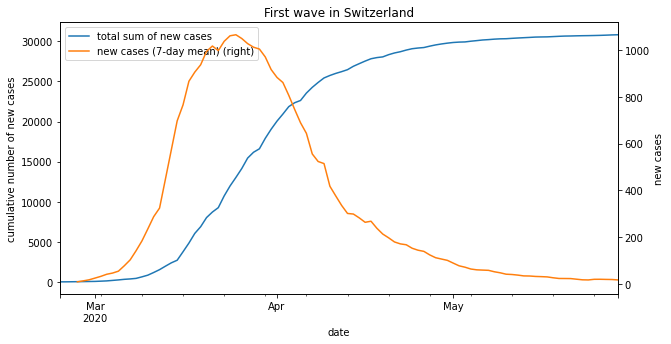

In [94]:
logCurve = pd.read_csv("data/FOPH/data/COVID19Cases_geoRegion.csv")
logCurve = logCurve[logCurve['geoRegion']=='CH'] #.set_index('datum')
#logCurve.index = pd.to_datetime(logCurve.index) 

logCurve['date'] = pd.to_datetime(logCurve['datum']) 
logCurve = logCurve[logCurve['date']<'2020-05-30']
logCurve = logCurve.set_index('date')
display(logCurve)
logCurve.rename(columns = {'sumTotal':'total sum of new cases', 'mean7d':'new cases (7-day mean)'},inplace=True)
fig = logCurve[['total sum of new cases','new cases (7-day mean)']].plot(kind='line', xlabel='date', ylabel='cumulative number of new cases', title='First wave in Switzerland', secondary_y=['new cases (7-day mean)'],figsize=(10,5))
#logCurve[[]].plot(kind='line', xlabel='date', ylabel='cumulative number of cases', title='Cumulative cases in Switzerland', figsize=(10,5))
fig.right_ax.set_ylabel('new cases')


In [2]:
# LOAD THE RESULTS

#validation1And2_labels = data[(data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,-split:-2]
#validation1And2_features = data[(data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)



# loading all the Keras and Sklearn models which were trained once
results = pd.read_csv("results.csv", low_memory=False)
results = results.append(pd.read_csv("results_sklearn.csv", low_memory=False))
results = results.append(pd.read_csv("results_sklearn_tuned.csv", low_memory=False))
results = results.append(pd.read_csv("results_sklearn_tuned2.csv", low_memory=False))

# loading all Keras models which were trained 30 times
resultSelection = pd.read_csv("results_selection.csv", low_memory=False)
resultSelection['modelClass'] = 'Keras mean'
results = results.append(resultSelection)

# loading all sklearn model which were trained 30 times
resultSelectionSklearn = pd.read_csv("results_selection_sklearn.csv", low_memory=False)
resultSelectionSklearn['modelClass'] = resultSelectionSklearn['modelClass'] + " mean"
results = results.append(resultSelectionSklearn)



# attach baselines
for task in outputCategories: # for all output tasks
    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week
        # get the ground truth
        groundtruth1 = validation1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = validation2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
   
        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = validation1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = validation2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        
        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))
        
        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
        results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse
        
        

   
results



,Unnamed: 0,modelClass,task,week,model rmse 1,model rmse 2,isMultiWeek,hiddenLayers,numberOfhiddenLayers,isTwoWay,...,modelId,modelIdNumber,l1_ratio,max_features,n_estimators,min_samples_leaf,tol,iteration,last value baseline 1 rmse,last value baseline 2 rmse
0,0,Keras,case_inz_entries_7dayAverage,0,8.750585,6.842526,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,6.339356,15.058855
1,1,Keras,case_inz_entries_7dayAverage,1,13.744389,9.309519,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,8.531462,25.559603
2,2,Keras,case_inz_entries_7dayAverage,2,18.621451,10.661099,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,10.986179,31.134417
3,3,Keras,case_inz_entries_7dayAverage,3,21.064762,12.526844,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,13.833168,33.595827
4,4,Keras,hosp_inz_entries_7dayAverage,0,0.404281,0.383035,True,[20],1.0,False,...,modelClass=Keras/isMultiWeek=True/hiddenLayers...,597,NaN,NaN,NaN,NaN,NaN,NaN,0.496069,0.634250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,6235,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,3,6.060057,3.227843,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,28.0,12.571834,15.186066
6236,6236,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,0,7.448474,3.416506,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,8.543653,9.377905
6237,6237,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,1,6.461476,3.234617,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,11.407756,13.201341
6238,6238,RandomForrest mean,workplaces_percent_change_from_baseline_7dayAv...,2,7.131314,3.213451,True,NaN,NaN,NaN,...,modelClass=RandomForrest/isMultiWeek=True/n_es...,0,NaN,auto,1000.0,4.0,NaN,29.0,13.628724,14.365826


In [ ]:
df = results.copy()



# modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean
# modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage/mean

'''
for task in outputCategories:
    temp = df[df['task']==task].groupby(['modelId','iteration']).sum().reset_index()
    temp['numberOfRanEpochs'] = temp['numberOfRanEpochs']/4
    display(max(temp['numberOfRanEpochs']))
    temp = temp[['modelId','numberOfRanEpochs']] #.set_index('modelId')

    display(temp[temp['modelId']=='modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage/mean'].describe())
    display(temp.groupby(['modelId']).mean().describe())
'''
df = df[df['task'] == 'workplaces_percent_change_from_baseline_7dayAverage']
df = df[(df['modelId']=='modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage') 
        | (df['modelId']=='modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage')]

df = df.groupby(['modelId','iteration']).sum().reset_index()

display(df[df['modelId']=='modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0/dropoutValue=0.2/learningRate=0.001/task=workplaces_percent_change_from_baseline_7dayAverage'].describe())
df[df['modelId']=='modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage'].describe()

In [ ]:
p = results[results['task']=='case_inz_entries_7dayAverage'][['modelId','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse']]
p['week'] = p['week'] + 1
# .groupby(['modelId']).sum()
# modelClass=XGB/isMultiWeek=False/n_estimators=500/alpha=10/lambda=10
# modelClass=Keras/isMultiWeek=False/hiddenLayers=[10, 10]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.2/learningRate=0.0001 

# p.groupby(['modelId']).sum()
display(p[p['modelId'] == 'modelClass=XGB/isMultiWeek=False/n_estimators=500/alpha=10/lambda=10'])
display(p[p['modelId'] == 'modelClass=Keras/isMultiWeek=False/hiddenLayers=[10, 10]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.2/learningRate=0.0001'])

In [ ]:
# OVERVIEW (for all weeks best estimator per target)
df = results.copy()
merged1 = pd.DataFrame()
merged2 = pd.DataFrame()
for week in range(0,numberOfOutputWeeks):
    temp = df[df['week']==week].groupby(['task']).apply(lambda x: x.sort_values(['rel. diff. to last value baseline 1'], ascending=False)).reset_index(drop=True)
    temp = temp.groupby(['task']).head(1)
    temp1 = temp[['task','rel. diff. to last value baseline 1']].set_index('task')
    temp2 = temp[['task','rel. diff. to last value baseline 2']].set_index('task')
    temp1.rename(columns = {'rel. diff. to last value baseline 1': str(week+1)}, inplace = True)
    temp2.rename(columns = {'rel. diff. to last value baseline 2': str(week+1)}, inplace = True)
    merged1 = merged1.append(temp1.transpose())
    merged2 = merged2.append(temp2.transpose())
    #.sort_values(['rsme'], ascending=False)
    #temp.plot(kind='bar', title="week_"+str(week))
    #plt.show()
    
merged1.plot(kind='line', title="validation set 1 scores", ylabel='rel. diff. to baseline', xlabel="week", figsize=(10,5))
merged2.plot(kind='line', title="validation set 2 scores", ylabel='rel. diff. to baseline', xlabel="week", figsize=(10,5))

In [ ]:
# MODEL COMPARISON (for all weeks and for all target best estimator per model class)
pd.options.display.max_rows = 11
for category in outputCategories:
    mergedAbs1 = pd.DataFrame()
    mergedAbs2 = pd.DataFrame()
    mergedRel1 = pd.DataFrame()
    mergedRel2 = pd.DataFrame()
    for week in range(0,numberOfOutputWeeks):
        temp = df[(df['week']==week)&(df['task']==category)].groupby(['modelClass']).apply(lambda x: x.sort_values(["rel. diff. to last value baseline 1"], ascending=False)).reset_index(drop=True)
        temp = temp.groupby(['modelClass']).head(1) #.sort_values(['rel. diff. to last value baseline 1'], ascending=False)
        
        # for absolut values plot
        temp1V1 = temp[['modelClass','model rmse 1','last value baseline 1 rmse']].set_index('modelClass')
        temp1V2 = temp[['modelClass','model rmse 2','last value baseline 2 rmse']].set_index('modelClass') 
        new_row1 = pd.Series(data={'rmse':temp1V1['last value baseline 1 rmse'].values[0]}, name='baseline')
        new_row2 = pd.Series(data={'rmse':temp1V2['last value baseline 2 rmse'].values[0]}, name='baseline')
        temp1V1.rename(columns = {'model rmse 1':'rmse'}, inplace = True)
        temp1V2.rename(columns = {'model rmse 2':'rmse'}, inplace = True)
        temp1V1.drop(['last value baseline 1 rmse'], inplace=True, axis=1)
        temp1V2.drop(['last value baseline 2 rmse'], inplace=True, axis=1)
        temp1V1 = temp1V1.append(new_row1, ignore_index=False).sort_values(['rmse'], ascending=False)
        temp1V2 = temp1V2.append(new_row2, ignore_index=False).sort_values(['rmse'], ascending=False)
        temp1V1.rename(columns = {'rmse':str(week+1)}, inplace=True)
        temp1V2.rename(columns = {'rmse':str(week+1)}, inplace=True)
        mergedAbs1 = mergedAbs1.append(temp1V1.transpose())
        mergedAbs2 = mergedAbs2.append(temp1V2.transpose())

        # for relative to baseline plot
        temp2V1 = temp[['modelClass','rel. diff. to last value baseline 1']].set_index('modelClass')
        temp2V2 = temp[['modelClass','rel. diff. to last value baseline 2']].set_index('modelClass')
        temp2V1.rename(columns = {'rel. diff. to last value baseline 1':'rel. diff. to baseline'}, inplace = True)
        temp2V2.rename(columns = {'rel. diff. to last value baseline 2':'rel. diff. to baseline'}, inplace = True)
        temp2V1 = temp2V1.sort_values(['rel. diff. to baseline'], ascending=True)
        temp2V2 = temp2V2.sort_values(['rel. diff. to baseline'], ascending=True)
        temp2V1.rename(columns = {'rel. diff. to baseline':str(week+1)}, inplace=True)
        temp2V2.rename(columns = {'rel. diff. to baseline':str(week+1)}, inplace=True)
        mergedRel1 = mergedRel1.append(temp2V1.transpose())
        mergedRel2 = mergedRel2.append(temp2V2.transpose())

    mergedAbs1.plot(kind='line',title=category + " (validation set 1 scores)",ylabel='rmse', xlabel="week", figsize=(20,10))
    mergedAbs2.plot(kind='line',title=category + " (validation set 2 scores)",ylabel='rmse', xlabel="week", figsize=(20,10))
    mergedRel1.plot(kind='line',title=category + " (validation set 1 scores)",ylabel='rel. diff. to baseline', xlabel="week", figsize=(20,10))
    mergedRel2.plot(kind='line',title=category + " (validation set 2 scores)",ylabel='rel. diff. to baseline', xlabel="week", figsize=(20,10))
    plt.show()

In [ ]:
# SINGLE VS. MULTI OUTPUT (for all weeks and for all targets plot single, multi, baseline per model class)
for modelClass in ['RandomForrest']: # 'RandomForrest', 'Lasso''Keras' ,'SGD','KernelRidge','MultiTaskLasso','MLP','KernelRidge','XGB','LGBM','Ridge','SVR','Keras'
    for category in outputCategories:
        merged1 = pd.DataFrame()
        merged2 = pd.DataFrame()
        for week in range(0,numberOfOutputWeeks):
            temp = df[(df['week']==week)&(df['task']==category)&(df['modelClass']==modelClass)].groupby(['isMultiWeek']).apply(lambda x: x.sort_values(["rel. diff. to last value baseline 1"], ascending=False)).reset_index(drop=True)
            temp = temp.groupby(['isMultiWeek']).head(1)
            temp1 = temp[['model rmse 1', 'last value baseline 1 rmse', 'isMultiWeek']].set_index('isMultiWeek')
            temp2 = temp[['model rmse 2', 'last value baseline 2 rmse', 'isMultiWeek']].set_index('isMultiWeek')
            new_row1 = pd.Series(data={'rmse':temp1['last value baseline 1 rmse'].values[0]}, name='baseline')
            new_row2 = pd.Series(data={'rmse':temp2['last value baseline 2 rmse'].values[0]}, name='baseline')
            temp1.rename(columns = {'model rmse 1':'rmse'}, inplace = True)
            temp2.rename(columns = {'model rmse 2':'rmse'}, inplace = True)
            temp1.drop(['last value baseline 1 rmse'], inplace=True, axis=1)
            temp2.drop(['last value baseline 2 rmse'], inplace=True, axis=1)
            temp1 = temp1.append(new_row1, ignore_index=False) #.sort_values(['rsme'], ascending=False)
            temp2 = temp2.append(new_row2, ignore_index=False)
            temp1.rename(columns = {'rmse':str(week+1)}, inplace=True)
            temp2.rename(columns = {'rmse':str(week+1)}, inplace=True)
            merged1 = merged1.append(temp1.transpose())
            merged2 = merged2.append(temp2.transpose())
            #temp.plot(kind='bar', title=modelClass+"_"+category+"_"+"week_"+str(week))
            #plt.show()
        merged1.plot(kind='line',title=modelClass+" "+category +" (validation set 1 scores)",ylabel='rmse', xlabel="week", figsize=(20,10))
        merged2.plot(kind='line',title=modelClass+" "+category +" (validation set 2 scores)",ylabel='rmse', xlabel="week", figsize=(20,10))

In [ ]:
'''
# model selection process (relative performance scaling and maximizing distance to origin)
from sklearn.preprocessing import MinMaxScaler

resultsCopy = results.copy()
resultsCopy = resultsCopy.drop_duplicates(['modelId'])
resultsCopy.drop(['task','Unnamed: 0','week','last value baseline 1 rmse','last value baseline 2 rmse','model rmse 1','model rmse 2'], axis=1, inplace=True)
attributesByModelId = resultsCopy.set_index('modelId')



pd.options.display.max_rows = 10

resultsCopy = results.copy()
resultsCopy = resultsCopy[['modelId','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse']]

# shift week number by one
resultsCopy['week'] = resultsCopy['week']+1


tasksDict = {}


#'testPositvity_7dayAverageBoth',
for task in ['case_inz_entries_7dayAverage',
             'hosp_inz_entries_7dayAverage',
             'death_inz_entries_7dayAverage',
             'testPositvity_7dayAverage',
             'transit_stations_percent_change_from_baseline_7dayAverage',
             'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    # filter by task
    taskResults = resultsCopy[resultsCopy['task']==task]
    display(taskResults.shape)
    
    # sum up the same machine learning models over all 4 weeks
    taskResults = taskResults.groupby(['modelId']).sum()
    
    # add relative score
    taskResults['rel. diff. to last value baseline 1'] = (taskResults['last value baseline 1 rmse']-taskResults['model rmse 1'])/taskResults['last value baseline 1 rmse']
    taskResults['rel. diff. to last value baseline 2'] = (taskResults['last value baseline 2 rmse']-taskResults['model rmse 2'])/taskResults['last value baseline 2 rmse']
    taskResults = taskResults.sort_values(['model rmse 1'], ascending=True)
    
    
    # add the attribute data for the models
    taskResults = taskResults.join(attributesByModelId)
    
    
    
    # filter so that only models which perform better than the baseline in both validation sets are consideres
    taskResults = taskResults[(taskResults['rel. diff. to last value baseline 1'] >= 0) & (taskResults['rel. diff. to last value baseline 2'] >= 0)]
    
    
    # only consider certain model classes
    # taskResults = taskResults[(taskResults['modelClass'] != 'Keras')]
    

    # selection algorithm
    scaler = MinMaxScaler()
    taskResults['rel. diff. to last value baseline 1 scaled'] = scaler.fit_transform(np.array(taskResults['rel. diff. to last value baseline 1']).reshape(-1, 1))
    taskResults['rel. diff. to last value baseline 2 scaled'] = scaler.fit_transform(np.array(taskResults['rel. diff. to last value baseline 2']).reshape(-1, 1))
    taskResults['distanceFromOrigin'] = (taskResults['rel. diff. to last value baseline 1 scaled']**2 + taskResults['rel. diff. to last value baseline 2 scaled']**2)**(1/2)
    taskResults.sort_values(by='distanceFromOrigin', ascending=False, inplace=True)

    
    # show the distribution of the relative performance for those models
    taskResults[["rel. diff. to last value baseline 1"]].plot.hist(by=None, bins=100, title=task+" performance distribution for validation set 1")
    taskResults[["rel. diff. to last value baseline 2"]].plot.hist(by=None, bins=100, title=task+" performance distribution for validation set 2")
    plt.show()
    #'modelIdNumber'
    display(taskResults.head(10)[['rel. diff. to last value baseline 1','rel. diff. to last value baseline 2','distanceFromOrigin','modelClass','model rmse 1','model rmse 2','modelIdNumber','numberOfRanEpochs']])
    
    # safe the summarized model results in dictionary
    tasksDict[task] = taskResults.copy()
    
    display("---------------------------------")
   
    
'''






'case_inz_entries_7dayAverage'

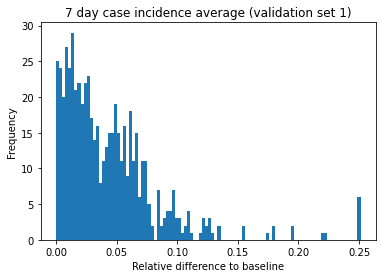

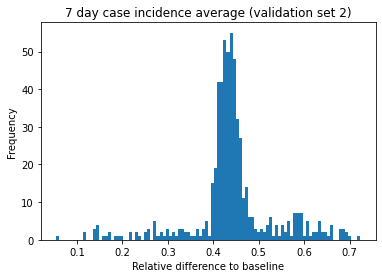

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250, 125]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0001/alpha=0.001/dropoutValue=0.5/learningRate=0.001",0.097370,0.643832,44.0,17.0,1.0,Keras,35.825515,37.521884
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[250, 125, 62]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.1/alpha=0.0001/dropoutValue=0.5/learningRate=0.001",0.092441,0.587224,53.0,46.0,2.0,Keras,36.021178,43.485433
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 1000]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=1/alpha=0/dropoutValue=0.2/learningRate=0.001",0.097903,0.578555,43.0,54.0,3.0,Keras,35.804386,44.398689
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 1000]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=1/alpha=1/dropoutValue=0.2/learningRate=0.001",0.100645,0.577289,38.0,56.0,4.0,Keras,35.695547,44.532079
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[30, 20]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.1/alpha=0.1/dropoutValue=0.5/learningRate=0.001",0.109310,0.562135,29.0,63.0,5.0,Keras,35.351637,46.128554
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[40, 20]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.1/alpha=0.01/dropoutValue=0.5/learningRate=0.001",0.094466,0.562099,50.0,64.0,6.0,Keras,35.940800,46.132350
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[250, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.1/alpha=1/dropoutValue=0.5/learningRate=0.001",0.108808,0.555188,31.0,65.0,7.0,Keras,35.371572,46.860379
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 1000]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=1/alpha=0.01/dropoutValue=0.2/learningRate=0.001",0.119877,0.550841,27.0,67.0,8.0,Keras,34.932215,47.318356
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[200, 100]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=1/alpha=0.0001/dropoutValue=0.3/learningRate=0.001",0.095923,0.548761,47.0,69.0,9.0,Keras,35.882970,47.537439


'---------------------------------'

'hosp_inz_entries_7dayAverage'

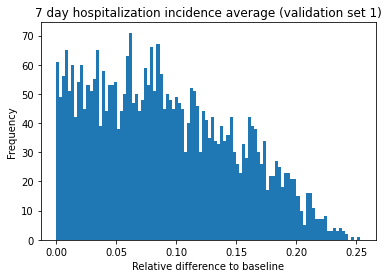

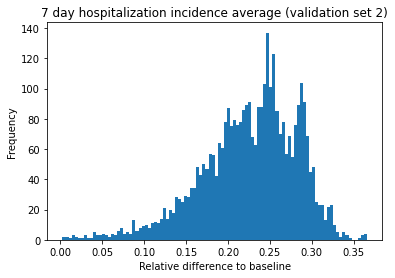

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=Keras/isMultiWeek=True/hiddenLayers=[80]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001,0.187829,0.294089,232.0,308.0,1.0,Keras,1.801036,2.702093
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[250, 100, 20]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.001/alpha=0/dropoutValue=0.2/learningRate=0.001",0.178512,0.294156,319.0,305.0,2.0,Keras,1.821697,2.701837
modelClass=Keras/isMultiWeek=True/hiddenLayers=[70]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.3/learningRate=0.0001,0.177585,0.296406,327.0,258.0,3.0,Keras,1.823752,2.693223
modelClass=Keras/isMultiWeek=True/hiddenLayers=[80]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.0001,0.176414,0.295370,336.0,280.0,4.0,Keras,1.826348,2.697188
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[225, 225]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.3/learningRate=0.001",0.172630,0.301684,373.0,189.0,5.0,Keras,1.834739,2.673022
modelClass=Keras/isMultiWeek=True/hiddenLayers=[300]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0/dropoutValue=0/learningRate=0.0001,0.172265,0.294453,382.0,301.0,6.0,Keras,1.835551,2.700701
modelClass=Keras/isMultiWeek=True/hiddenLayers=[125]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0/dropoutValue=0.5/learningRate=0.0001,0.174048,0.290654,353.0,386.0,7.0,Keras,1.831596,2.715241
modelClass=Keras/isMultiWeek=True/hiddenLayers=[200]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0/dropoutValue=0.5/learningRate=0.0001,0.178714,0.290575,317.0,388.0,8.0,Keras,1.821248,2.715545
modelClass=Keras/isMultiWeek=True/hiddenLayers=[125]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.01/dropoutValue=0.5/learningRate=0.0001,0.194740,0.290503,175.0,389.0,9.0,Keras,1.785710,2.715818


'---------------------------------'

'death_inz_entries_7dayAverage'

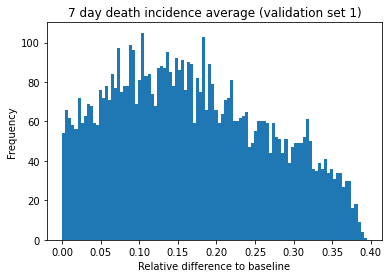

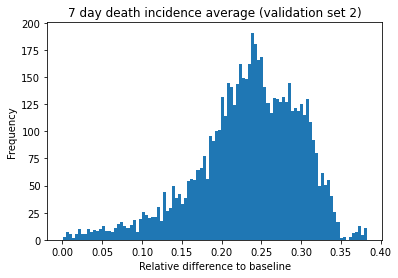

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=Keras/isMultiWeek=True/hiddenLayers=[150]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.0001/alpha=0.001/dropoutValue=0.5/learningRate=0.001,0.330742,0.304538,422.0,804.0,1.0,Keras,0.610016,1.418703
modelClass=Keras/isMultiWeek=True/hiddenLayers=[40]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.2/learningRate=0.001,0.293495,0.302774,873.0,862.0,2.0,Keras,0.643965,1.422303
modelClass=Keras/isMultiWeek=True/hiddenLayers=[175]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.01/dropoutValue=0.2/learningRate=0.001,0.295355,0.302086,854.0,883.0,3.0,Keras,0.642270,1.423705
modelClass=Keras/isMultiWeek=True/hiddenLayers=[90]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.01/dropoutValue=0.2/learningRate=0.001,0.317394,0.301904,573.0,889.0,4.0,Keras,0.622182,1.424077
modelClass=Keras/isMultiWeek=True/hiddenLayers=[40]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0/learningRate=0.001,0.292808,0.301882,878.0,890.0,5.0,Keras,0.644592,1.424121
modelClass=Keras/isMultiWeek=True/hiddenLayers=[175]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.2/learningRate=0.001,0.287552,0.305123,944.0,788.0,6.0,Keras,0.649382,1.417510
modelClass=Keras/isMultiWeek=True/hiddenLayers=[70]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0/dropoutValue=0.2/learningRate=0.001,0.280476,0.312895,1028.0,549.0,7.0,Keras,0.655832,1.401655
modelClass=Keras/isMultiWeek=True/hiddenLayers=[300]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0/dropoutValue=0.2/learningRate=0.001,0.279654,0.304331,1045.0,811.0,8.0,Keras,0.656581,1.419125
modelClass=Keras/isMultiWeek=True/hiddenLayers=[70]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.01/dropoutValue=0.3/learningRate=0.0001,0.277406,0.302515,1076.0,872.0,9.0,Keras,0.658630,1.422830


'---------------------------------'

'testPositvity_7dayAverage'

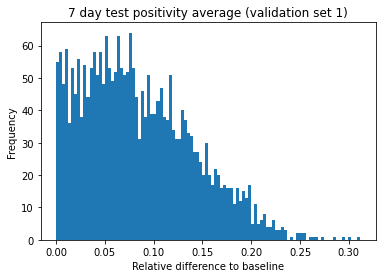

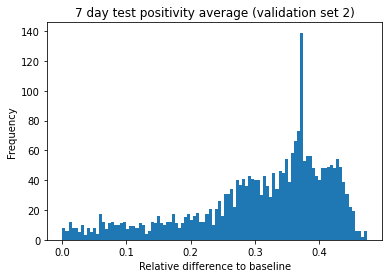

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=Keras/isMultiWeek=True/hiddenLayers=[200]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0/alpha=0/dropoutValue=0/learningRate=0.001,0.261670,0.451673,8.0,31.0,1.0,Keras,0.081268,0.161680
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[225, 225]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001",0.232547,0.449059,20.0,45.0,2.0,Keras,0.084473,0.162451
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[225, 112, 56]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0.2/learningRate=0.0001",0.223922,0.445410,30.0,60.0,3.0,Keras,0.085423,0.163527
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[225, 225]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.001",0.204468,0.446567,68.0,54.0,4.0,Keras,0.087564,0.163186
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.001",0.204222,0.449628,69.0,40.0,5.0,Keras,0.087591,0.162283
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 500, 250]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001",0.231157,0.442892,21.0,79.0,6.0,Keras,0.084626,0.164269
modelClass=Keras/isMultiWeek=True/hiddenLayers=[350]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0/alpha=0.001/dropoutValue=0/learningRate=0.0001,0.197496,0.464190,88.0,9.0,7.0,Keras,0.088331,0.157989
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 100, 50]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001",0.218005,0.439393,39.0,100.0,8.0,Keras,0.086074,0.165301
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[300, 150, 75]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.001",0.192660,0.443180,111.0,77.0,9.0,Keras,0.088864,0.164185


'---------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

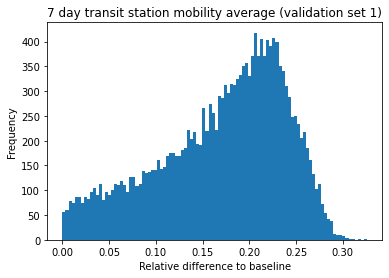

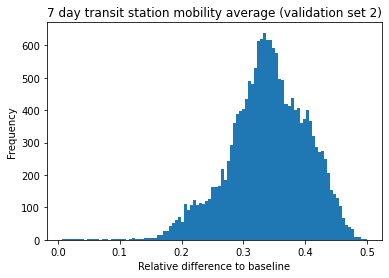

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001",0.280905,0.454751,168.0,321.0,1.0,Keras,24.623930,25.795492
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[175, 87, 40]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0.2/learningRate=0.0001",0.301546,0.451475,11.0,395.0,2.0,Keras,23.917139,25.950507
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 100, 50]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.01/alpha=0.01/dropoutValue=0.2/learningRate=0.0001",0.275624,0.450799,301.0,417.0,3.0,Keras,24.804781,25.982489
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[200, 200]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.01/dropoutValue=0.2/learningRate=0.001",0.268970,0.447059,526.0,519.0,4.0,Keras,25.032641,26.159435
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 400]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0/dropoutValue=0.5/learningRate=0.0001",0.268044,0.455584,563.0,286.0,5.0,Keras,25.064357,25.756092
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 200]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.01/dropoutValue=0.5/learningRate=0.0001",0.266830,0.443889,612.0,623.0,6.0,Keras,25.105903,26.309368
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 350]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0/dropoutValue=0.5/learningRate=0.0001",0.266108,0.451007,640.0,407.0,7.0,Keras,25.130652,25.972640
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[300, 150, 75]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0001/alpha=0/dropoutValue=0.2/learningRate=0.001",0.265254,0.451684,686.0,389.0,8.0,Keras,25.159899,25.940606
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[300, 150, 75]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.0001",0.265157,0.452509,693.0,371.0,9.0,Keras,25.163191,25.901557


'---------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

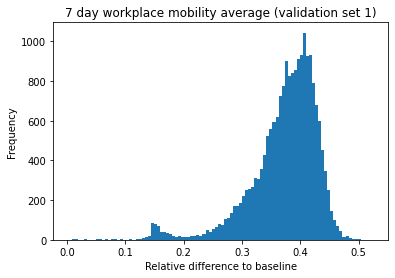

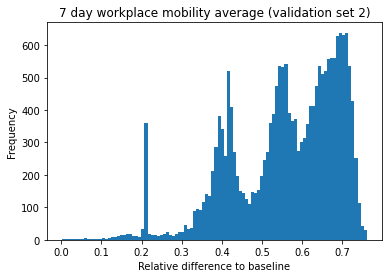

,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2,rank1,rank2,overallRank,modelClass,model rmse 1,model rmse 2
modelId,,,,,,,,
modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0/learningRate=0.001,0.469116,0.740470,76.0,130.0,1.0,Keras,24.501359,13.529619
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[1000, 1000]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.001",0.446236,0.725334,664.0,688.0,2.0,Keras,25.557280,14.318651
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.0001",0.469027,0.723143,78.0,825.0,3.0,Keras,24.505454,14.432863
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[400, 200, 100]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0/learningRate=0.001",0.443664,0.732516,838.0,330.0,4.0,Keras,25.675992,13.944244
modelClass=Keras/isMultiWeek=True/hiddenLayers=[400]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0/dropoutValue=0.2/learningRate=0.001,0.463921,0.722011,130.0,896.0,5.0,Keras,24.741101,14.491905
modelClass=Keras/isMultiWeek=True/hiddenLayers=[500]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.001,0.445864,0.721897,685.0,907.0,6.0,Keras,25.574467,14.497813
modelClass=Keras/isMultiWeek=True/hiddenLayers=[200]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.2/learningRate=0.001,0.442544,0.724233,912.0,769.0,7.0,Keras,25.727706,14.376056
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.01/alpha=0.0001/dropoutValue=0.3/learningRate=0.001",0.459212,0.720534,218.0,999.0,8.0,Keras,24.958438,14.568906
modelClass=Keras/isMultiWeek=True/hiddenLayers=[500]/numberOfhiddenLayers=1/isTwoWay=False/l1reg=0.01/alpha=0.001/dropoutValue=0.3/learningRate=0.001,0.443926,0.719103,817.0,1100.0,9.0,Keras,25.663919,14.643487


'---------------------------------'

In [3]:
# model selection process (rank iterative)
# first we compute the attributes of all estimators, they are defined by the model id
# so we have multiple entries because of the weeks, tasks, iterations

resultsCopy = results.copy() 
resultsCopy = resultsCopy.drop_duplicates(['modelId'])
resultsCopy.drop(['task','Unnamed: 0','week','last value baseline 1 rmse','last value baseline 2 rmse','model rmse 1','model rmse 2', 'iteration'], axis=1, inplace=True)
attributesByModelId = resultsCopy.set_index('modelId')



pd.options.display.max_rows = 10

# we again copy the results and look only at the interested part
resultsCopy = results.copy()
resultsCopy = resultsCopy[['modelId','modelClass','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse','iteration']]

# shift week number by one
resultsCopy['week'] = resultsCopy['week']+1


tasksDict = {}
rankedTasksDict = {}


for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    
    # filter by task
    df = resultsCopy[resultsCopy['task']==task]

    
    # sum up the same machine learning models over all 4 weeks which were trainded only once
    taskResults = df[~df['modelClass'].str.contains("mean")].groupby(['modelId']).sum()
    #taskResults = taskResults.drop(['iteration'], axis=1)
    
    # get the models which were trained 30 times, for every iteration and model do the same as for the models
    # which were trained only once
    temp = df[df['modelClass'].str.contains("mean")].groupby(['modelId','iteration']).sum().reset_index()
    # add tag to the id so the modelid stays unique when we later merge the dataframe with the multiple and single
    # trained models
    temp['modelId'] = temp['modelId']+"/mean"
    # compute the mean from the iterations
    temp = temp.groupby(['modelId']).mean().drop(['iteration'], axis=1)
    
    
    
    
    # add the attribute data for the models which were trained only once
    taskResults = taskResults.join(attributesByModelId)
    
    #other join (we reset, modify and set the index again for an index join)
    attributesByModelIdForMean = attributesByModelId.reset_index()
    attributesByModelIdForMean['modelId'] = attributesByModelIdForMean['modelId'] +"/mean"
    attributesByModelIdForMean = attributesByModelIdForMean.set_index('modelId')
    temp = temp.join(attributesByModelIdForMean)
    
    # merge both single and multiple trained estimators
    taskResults = taskResults.append(temp)
    
    # add relative score based on the last value baseline
    taskResults['rel. diff. to last value baseline 1'] = (taskResults['last value baseline 1 rmse']-taskResults['model rmse 1'])/taskResults['last value baseline 1 rmse']
    taskResults['rel. diff. to last value baseline 2'] = (taskResults['last value baseline 2 rmse']-taskResults['model rmse 2'])/taskResults['last value baseline 2 rmse']
    #taskResults = taskResults.sort_values(['model rmse 1'], ascending=True)
    
    
    # safe the summarized model results in dictionary
    tasksDict[task] = taskResults.copy()
    
    # filter so that only models which perform better than the baseline in both validation sets are considered
    # this filters estimator which were highly overfitted for one of both validation sets
    taskResults = taskResults[(taskResults['rel. diff. to last value baseline 1'] >= 0) & (taskResults['rel. diff. to last value baseline 2'] >= 0)]
    

    # TURN THIS OFF IF YOU WANT TO INCLUDE THE PERFORMANCE OF MODELS WHICH WERE TRAINED ONLY ONCE
    # ATTENTION: THE ALGORITHM WILL THEN SELECT MODELS WHICH WERE LUCKY ONCE BUT THEIR PERFORMANCE IS SIGNIFICANTLY 
    # DEACREASING ON AVERAGE
    taskResults = taskResults[~(taskResults['modelClass'].str.contains("mean"))]
    
    # Selection algorihtm: the algorithm works as follow, all estimators get two ranks based on their relative
    # performance for both validation sets, after that we have a sliding rank bound which starts from 1 and increases
    # whith each iteration by one. In every iteration we compute the intersection of the two sets of estimator which
    # have a rank lower or equal than our ranking bound. If the size of computed intersection increased we found one
    # or two new estimators. We then give those estimator the overall rank kBest and increas kBest by 1.
    # We stop when the intersection size is as large as the input (n)
    # The worst case for the number of iterations is n
    
    taskResults['rank1'] = taskResults['rel. diff. to last value baseline 1'].rank(ascending = False)
    taskResults['rank2'] = taskResults['rel. diff. to last value baseline 2'].rank(ascending = False)
    
    taskResults['overallRank'] = np.nan
    rankBound = 1
    kBest = 1 
    #minIntersectionSizeStop = 10
    previousIntersection = pd.DataFrame()
    
    while (previousIntersection.shape[0] < taskResults.shape[0]): # we stop at the latest when we went through the whole dataframe
        # compute intersection
        intersection = taskResults[(taskResults['rank1'] <= rankBound) & (taskResults['rank2'] <= rankBound)]
        
        # check intersection
        if intersection.shape[0] > previousIntersection.shape[0]:
            # we found more estimatiors in our intersection than before
         
            estimatorRows =  intersection[['overallRank']]
            
            difference = (estimatorRows.index).difference(previousIntersection.index, sort=False)
            
            # update the overall rank of the new found estimator
            taskResults.loc[difference, 'overallRank'] = kBest
            
            kBest = kBest + 1
            previousIntersection = intersection
            '''
            if(intersection.shape[0] >= minIntersectionSizeStop):
                break
            '''
                
        rankBound = rankBound + 1
        

    taskResults = taskResults.sort_values(['overallRank'], ascending=True)

    
    # show the distribution of the relative performance for those models
    figure = taskResults[["rel. diff. to last value baseline 1"]].plot.hist(by=None, bins=100, title=plottingDict[task] +" (validation set 1)", xlabel="relative difference to baseline", legend=False)
    figure.set_xlabel("Relative difference to baseline")
    figure.set_ylabel("Frequency")
    plt.show()
    #figure.get_figure().savefig('plots/performanceDistribution/'+task+'_1.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
    figure = taskResults[["rel. diff. to last value baseline 2"]].plot.hist(by=None, bins=100, title=plottingDict[task]+" (validation set 2)", xlabel="relative difference to baseline", legend=False)
    figure.set_xlabel("Relative difference to baseline")
    figure.set_ylabel("Frequency")
    plt.show()
    #figure.get_figure().savefig('plots/performanceDistribution/'+task+'_2.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
    
    # show top estimators
    display(taskResults[taskResults['overallRank'].notna()].head(10)[['rel. diff. to last value baseline 1','rel. diff. to last value baseline 2','rank1','rank2','overallRank','modelClass','model rmse 1','model rmse 2']])
    
    rankedTasksDict[task] = taskResults.copy()
    
    display("---------------------------------")
    

In [ ]:
# SELECTED MODELS TRAINED ON TRAINING DATA

pd.options.display.max_columns = 25



#modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001
                  
selectedDict = {
    'case_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05',
    'hosp_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001',
    'death_inz_entries_7dayAverage':'modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=0.0001',
    'testPositvity_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001',
    'transit_stations_percent_change_from_baseline_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001',
    'workplaces_percent_change_from_baseline_7dayAverage':'modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8'
}


temp = results.copy()
for task in outputCategories: 
    t1 = temp[(~temp['modelClass'].str.contains("mean")) 
                 & (temp['task'] == task)
                 & (temp['modelId'] == selectedDict[task])
                ]
    t1['rel. diff. to last value baseline 1'] = (t1['last value baseline 1 rmse']-t1['model rmse 1'])/t1['last value baseline 1 rmse']
    t1['rel. diff. to last value baseline 2'] = (t1['last value baseline 2 rmse']-t1['model rmse 2'])/t1['last value baseline 2 rmse']
    


    display(t1[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2', 'modelIdNumber']])

In [ ]:
# SELECTED MODELS TRAINED ON TRAINING + VALIDATION DATA
df = pd.read_csv("models/trainedOnTrainingAndValidationData/correspondingResults.csv")


for task in outputCategories:
    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week
        # get the ground truth
        groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
   
        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        
        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))
        
        df.loc[(df.task == task) & (df.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
        df.loc[(df.task == task) & (df.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse




for task in outputCategories:
    temp = df.copy()
    temp = temp[temp['task']==task]
    
    temp['rel. diff. to last value baseline 1'] = (temp['last value baseline 1 rmse']-temp['model rmse 1'])/temp['last value baseline 1 rmse']
    temp['rel. diff. to last value baseline 2'] = (temp['last value baseline 2 rmse']-temp['model rmse 2'])/temp['last value baseline 2 rmse']
    
    display(temp[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2']])
    
    t = temp[['modelClass','task','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse', 'rel. diff. to last value baseline 1','rel. diff. to last value baseline 2']].drop(['rel. diff. to last value baseline 1','rel. diff. to last value baseline 2'],axis=1).sum()
    t['rel. diff. to last value baseline 1'] = (t['last value baseline 1 rmse']-t['model rmse 1'])/t['last value baseline 1 rmse']
    t['rel. diff. to last value baseline 2'] = (t['last value baseline 2 rmse']-t['model rmse 2'])/t['last value baseline 2 rmse']
    display(t)


In [ ]:
# FEATURE IMPORTANCE TRAINING SET
import eli5

# CASES
# load model
model = load('models/trainedOnTrainingData/139_case_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh', title='7 day case incidence average',figsize=(10,7))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()

#figure.get_figure().savefig('plots/importanceAfterTraining/cases.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# HOSPITALIZATIONS
model = load('models/trainedOnTrainingData/388_hosp_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh', title='7 day hospitalization incidence average',figsize=(10,10))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/hospitalizations.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# DEATHS
model = load('models/trainedOnTrainingData/207_death_inz_entries_7dayAverage_sklearn.pkl')
#for week in [0,1,2,3]:
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(["week 0"],ascending=True)
figure = temp.plot(kind='barh', title='7 day death incidence average',figsize=(10,10))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/deaths.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))




# TEST POSITIVITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingData/12483_testPositvity_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", title='7 day test positivity average',figsize=(10,7))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/testpositivity.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))


# TRANSIT STATION MOBILITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingData/18186_transit_stations_percent_change_from_baseline_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", title='7 day transit station mobility average',figsize=(10,9))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/transitstation.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))





# WORKINGPLACE MOBILITY
model = load('models/trainedOnTrainingData/327_workplaces_percent_change_from_baseline_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.feature_importances_, index=train_features.columns, columns=['feature importance'])
temp.index.names = ['features']
temp = temp.sort_values(['feature importance'], ascending = False).head(20)
figure = temp.plot(kind='barh', title='7 day working mobility average',figsize=(10,7))
figure.set_xlabel("feature importance")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTraining/workingplace.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), target_names=['week 1','week 2','week 3','week 4']))



In [ ]:
# FEATURE IMPORTANCE TRAINING + VALIDATION SET
import eli5


# CASES
# load model
model = load('models/trainedOnTrainingAndValidationData/139_case_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
temp = temp[(temp['week 0'] != 0) | (temp['week 1'] != 0) | (temp['week 2'] != 0) | (temp['week 3'] != 0)].sort_values(['week 3'],ascending=True)
figure = temp.plot(kind='barh', title='7 day case incidence average',figsize=(10,7))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/cases.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# HOSPITALIZATIONS
model = load('models/trainedOnTrainingAndValidationData/388_hosp_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)

threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0

temp = temp[(temp['week 0'].abs() > threshold) | (temp['week 1'].abs() > threshold) | (temp['week 2'].abs() > threshold) | (temp['week 3'].abs() > threshold)].sort_values(['week 3','week 0','week 1','week 2'],ascending=True)
figure = temp.plot(kind='barh', title='7 day hospitalization incidence average',figsize=(10,9))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/hospitalizations.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
plt.show()

display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# DEATHS
model = load('models/trainedOnTrainingAndValidationData/207_death_inz_entries_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.coef_.transpose(), columns=['week 0','week 1','week 2','week 3'],index=train_features.columns)
threshold = 0.2
temp['week 0'][temp['week 0'].abs() < threshold] = 0
temp['week 1'][temp['week 1'].abs() < threshold] = 0
temp['week 2'][temp['week 2'].abs() < threshold] = 0
temp['week 3'][temp['week 3'].abs() < threshold] = 0
temp = temp[(temp['week 0'].abs() > threshold) | (temp['week 1'].abs() > threshold) | (temp['week 2'].abs() > threshold) | (temp['week 3'].abs() > threshold)].sort_values(['week 0','week 1','week 2','week 3'],ascending=True)
figure = temp.plot(kind='barh', title='7 day death incidence average',figsize=(10,9))
figure.set_xlabel("coefficient size")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/deaths.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), top=(5,5), target_names=['week 1','week 2','week 3','week 4']))



# TEST POSITIVITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingAndValidationData/12483_testPositvity_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", title='7 day test positivity average', figsize=(10,8))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/testpositivity.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))


# TRANSIT STATION MOBILITY
# permutation importance
df = pd.read_csv("featureImportance/fromTrainingAndValidationData/18186_transit_stations_percent_change_from_baseline_7dayAverage.csv")
df = df.set_index("Unnamed: 0")
df.index.rename('features', inplace=True)
figure = df[["importances_mean"]].head(20).plot(kind="barh", title='7 day transit station mobility average', figsize=(10,8))
figure.set_ylabel("")
figure.set_xlabel("permutation importance")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/transitstation.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))





# WORKINGPLACE MOBILITY
model = load('models/trainedOnTrainingAndValidationData/327_workplaces_percent_change_from_baseline_7dayAverage_sklearn.pkl')
temp = pd.DataFrame(model.feature_importances_, index=train_features.columns, columns=['feature importance'])
temp.index.names = ['features']
temp = temp.sort_values(['feature importance'], ascending = False).head(20)
figure = temp.plot(kind='barh', title='7 day working mobility average',figsize=(10,7))
figure.set_xlabel("feature importance")
figure.set_ylabel("")
plt.show()
#figure.get_figure().savefig('plots/importanceAfterTrainingValidating/workingplace.png', bbox_inches=matplotlib.transforms.Bbox([[-10, -10], [10, 10]]))
display(eli5.show_weights(model, feature_names=train_features.columns.tolist(), target_names=['week 1','week 2','week 3','week 4']))


In [ ]:
# performance on validation set
selectedDict = {
    'case_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage',
    'hosp_inz_entries_7dayAverage':'modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.0139999999999999/tol=0.0001/task=hosp_inz_entries_7dayAverage',
    'death_inz_entries_7dayAverage':'modelClass=Lasso/isMultiWeek=True/alpha=0.0009/tol=0.0001/task=death_inz_entries_7dayAverage',
    'testPositvity_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0.0/alpha=0.0001/dropoutValue=0.0/learningRate=0.0001/task=testPositvity_7dayAverage',
    'transit_stations_percent_change_from_baseline_7dayAverage':'modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage',
    'workplaces_percent_change_from_baseline_7dayAverage':'modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage'
}

df = results.copy()
for task in outputCategories:
    display(task)
    
    temp = df[df['task'] == task]
    
    temp = temp[(temp['modelId']==selectedDict[task])]

    temp = temp.groupby(['modelId','iteration']).sum().reset_index()
    
    temp['numberOfRanEpochs'] = temp['numberOfRanEpochs'] / 4
    display(temp.describe())
    
    temp['rel. diff. to last value baseline 1'] = (temp['last value baseline 1 rmse']-temp['model rmse 1'])/temp['last value baseline 1 rmse']
    temp['rel. diff. to last value baseline 2'] = (temp['last value baseline 2 rmse']-temp['model rmse 2'])/temp['last value baseline 2 rmse']
    
    
    v1 = temp[['rel. diff. to last value baseline 1']].values.ravel()
    v2 = temp[['rel. diff. to last value baseline 2']].values.ravel()
    
    
    display("rel. diff. to last value baseline 1 mean: " + str(np.mean(v1)))
    display("rel. diff. to last value baseline 1 standard deviation: " + str(np.std(v1)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v1), scale=st.sem(v1))))
    print(" ")
    display("rel. diff. to last value baseline 2 mean: " + str(np.mean(v2)))
    display("rel. diff. to last value baseline 2 standard deviation: " + str(np.std(v2)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v2), scale=st.sem(v2))))
    display("--------------------------------")
    
   

'case_inz_entries_7dayAverage'

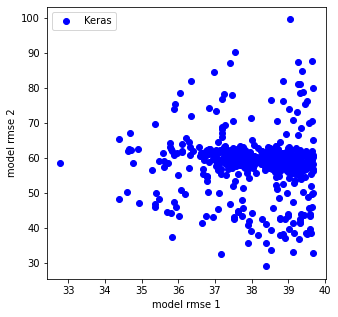

'---------------------------------------------'

'hosp_inz_entries_7dayAverage'

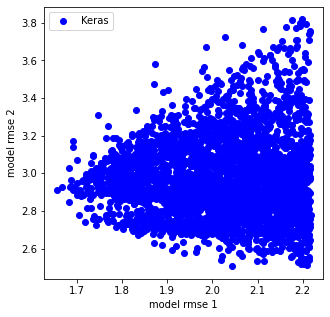

'---------------------------------------------'

'death_inz_entries_7dayAverage'

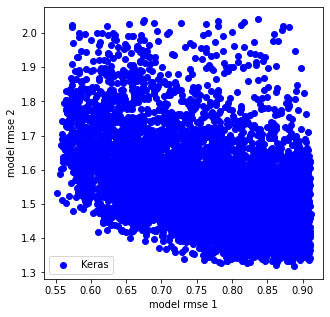

'---------------------------------------------'

'testPositvity_7dayAverage'

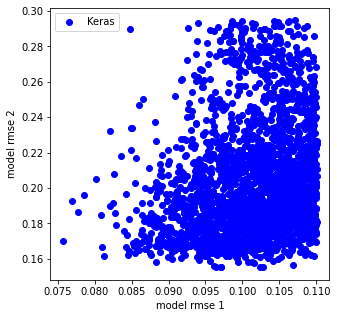

'---------------------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

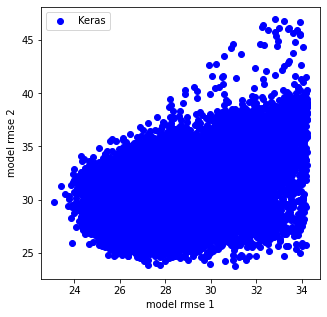

'---------------------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

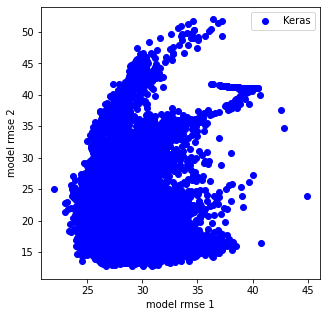

'---------------------------------------------'

In [8]:
for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    #temp = rankedTasksDict[task].head(100)
    #display(temp[temp['modelClass']!='Keras'])
    #display(temp[temp['modelClass']=='Keras'])
    #temp[temp['modelClass']=='Keras'].to_csv("top100/"+task+".csv")
    
    df = rankedTasksDict[task]
    
    plt.figure(figsize=(5,5))
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Keras'],
            df['model rmse 2'][df.modelClass == 'Keras'],
           marker='o',
           color='blue',
           label='Keras',
           alpha=1)
    '''
    plt.scatter(df['model rmse 1'][df.modelClass == 'Keras mean'],
            df['model rmse 2'][df.modelClass == 'Keras mean'],
           marker='o',
           color='red',
           label='Keras mean',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'RandomForrest'],
            df['model rmse 2'][df.modelClass == 'RandomForrest'],
           marker='o',
           color='yellow',
           label='RandomForrest',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Ridge'],
            df['model rmse 2'][df.modelClass == 'Ridge'],
           marker='o',
           label='Ridge',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Lasso'],
            df['model rmse 2'][df.modelClass == 'Lasso'],
           marker='o',
           label='Lasso',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'MultiTaskLasso'],
            df['model rmse 2'][df.modelClass == 'MultiTaskLasso'],
           marker='o',
           label='MultiTaskLasso',
           alpha=1)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'ElasticNet'],
            df['model rmse 2'][df.modelClass == 'ElasticNet'],
           marker='o',
           color='grey',
           label='ElasticNet',
           alpha=1)
    '''
    plt.xlabel('model rmse 1')
    plt.ylabel('model rmse 2')
    plt.legend()

    plt.show()
   
    display("---------------------------------------------")
    
    

In [ ]:
lists = []
for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverageBoth',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    df = tasksDict[task]
    
    
    
    # Keras
    '''
    df = df[(df['isTwoWay']==False)
           & (df['numberOfhiddenLayers']!=8)
           & (df['isMultiWeek']==True)
           & (df['numberOfhiddenLayers']!=7)
           & (df['alpha']!=10)
           & (df['alpha']!=100)
           & (df['l1reg']!=10)
           & (df['l1reg']!=100)
           & (df['numberOfhiddenLayers']!=6)]
    '''
    
    
    
    for parameter in ['hiddelLayers']:
    #for parameter in ['isMultiWeek','numberOfhiddenLayers','hiddelLayers','isTwoWay','l1reg','alpha','dropoutValue','learningRate']:
        display("--------"+parameter+"-------")
        for error in ['distanceFromOrigin']:
        #for error in ['model rmse 1', 'model rmse 2']:
            lists.append(df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).describe().sort_values(by='max', axis=1, ascending=False).iloc[:,-40:].columns.tolist())
            display(df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).describe().sort_values(by='max', axis=1, ascending=False).iloc[:,-40:].columns.tolist())
            #display(df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).describe().sort_values(by='max', axis=1, ascending=False))
            #display(df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).describe().sort_values(by='75%', axis=1, ascending=False))
            #display(df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).describe().sort_values(by='50%', axis=1, ascending=False))
            #df[df['modelClass']=='Keras'][[error,parameter]].pivot(columns=parameter, values=error).plot(kind="box", title = parameter+" effect "+error, ylabel=error, xlabel=parameter, figsize=(10,5))
            #plt.show()       
    
    
    display("---------------------------------------------")

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

#display(intersection(lists[0],lists[1]))
init = intersection(lists[0],lists[1])
for i in range(1,len(lists)-1):
    init = intersection(init, lists[i])
display(init)

In [ ]:
for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverageBoth',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    df = tasksDict[task]
    df = df[['model rmse 1','model rmse 2','modelClass']]
    display(df.shape)
    
    df = df[(df['model rmse 1'] < df['model rmse 1'].mean()) & 
           (df['model rmse 2'] < df['model rmse 2'].mean())
           ]
    df = df[(df['model rmse 1'] < df['model rmse 1'].mean() + 3*df['model rmse 1'].std()) & 
           (df['model rmse 2'] < df['model rmse 2'].mean() + 3*df['model rmse 2'].std())
           ]
    display(df.shape)
    #display(df['model rmse 1'].mean())
    #+ 3*df['model rmse 1'].std()

    
    plt.figure(figsize=(15,15))
    plt.scatter(df['model rmse 1'][df.modelClass == 'Keras'],
            df['model rmse 2'][df.modelClass == 'Keras'],
           marker='o',
           color='blue',
           label='Keras',
           alpha=0.2)
    plt.scatter(df['model rmse 1'][df.modelClass == 'LGBM'],
            df['model rmse 2'][df.modelClass == 'LGBM'],
           marker='o',
           color='red',
           label='LGBM',
           alpha=0.4)
    plt.scatter(df['model rmse 1'][df.modelClass == 'XGB'],
            df['model rmse 2'][df.modelClass == 'XGB'],
           marker='o',
           color='green',
           label='XGB',
           alpha=0.4)
    plt.scatter(df['model rmse 1'][df.modelClass == 'RandomForrest'],
            df['model rmse 2'][df.modelClass == 'RandomForrest'],
           marker='o',
           color='yellow',
           label='RandomForrest',
           alpha=0.4)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Ridge'],
            df['model rmse 2'][df.modelClass == 'Ridge'],
           marker='o',
           label='Ridge',
           alpha=0.4)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'Lasso'],
            df['model rmse 2'][df.modelClass == 'Lasso'],
           marker='o',
           label='Lasso',
           alpha=0.4)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'MultiTaskLasso'],
            df['model rmse 2'][df.modelClass == 'MultiTaskLasso'],
           marker='o',
           label='MultiTaskLasso',
           alpha=0.4)
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'SVR'],
            df['model rmse 2'][df.modelClass == 'SVR'],
           marker='o',
           label='SVR',
           alpha=0.4)
    
    
    plt.scatter(df['model rmse 1'][df.modelClass == 'SGD'],
            df['model rmse 2'][df.modelClass == 'SGD'],
           marker='o',
           label='SGD',
           alpha=0.4)
    ''
    plt.scatter(df['model rmse 1'][df.modelClass == 'KernelRidge'],
            df['model rmse 2'][df.modelClass == 'KernelRidge'],
           marker='o',
           label='KernelRidge',
           alpha=0.4)
   
    plt.xlabel('model rmse 1')
    plt.ylabel('model rmse 2')
    plt.legend()

    plt.show()
   
    display("---------------------------------------------")

In [ ]:
for task in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverageBoth',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]:
    display(task)
    df = tasksDict[task]
    df = df[df['modelClass']=='Keras']
    parameterOfInterest = 'numberOfhiddenLayers' #'isMultiWeek','numberOfhiddenLayers','hiddelLayers','isTwoWay','l1reg','alpha','dropoutValue','learningRate'
    df = df[['model rmse 1','model rmse 2', parameterOfInterest]]
    
    plt.figure(figsize=(15,15))
    for possibleValue in df[parameterOfInterest].unique():
        plt.scatter(df['model rmse 1'][df[parameterOfInterest] == possibleValue],
                df['model rmse 2'][df[parameterOfInterest] == possibleValue],
               marker='o',
               label=possibleValue,
               alpha=0.4)
    plt.xlabel('model rmse 1')
    plt.ylabel('model rmse 2')
    plt.legend()

    plt.show()
   
    display("---------------------------------------------")
    

In [15]:
# TEST SET TEST
from sklearn.pipeline import Pipeline


# settings:
numberOfInputWeeks = 3 # must be equal to the number of input weeks set in data preperator
numberOfOutputWeeks = 4 # must be equal to the number of output week set in data preperator



# data preperation
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']
data = pd.read_csv("completedata.csv")


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]
numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2

train_features = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[(data['category']=='train') | (data['category']=='validation 1') | (data['category']=='validation 2')].iloc[:,-split:-2]

test1_features = data[data['category']=='test 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test1_labels = data[data['category']=='test 1'].iloc[:,-split:-2]
test2_features = data[data['category']=='test 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
test2_labels = data[data['category']=='test 2'].iloc[:,-split:-2]
test1And2_labels = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,-split:-2]
test1And2_features = data[(data['category']=='test 1') | (data['category']=='test 2')].iloc[:,0:-split].drop(['lastInputDay'], axis=1)

pip = Pipeline([('minmax_scaler', MinMaxScaler())])
X_train = pip.fit_transform(train_features[train_features.columns].values)
X_test1 = pip.transform(test1_features[train_features.columns].values)
X_test2 = pip.transform(test2_features[train_features.columns].values)
X_test1And2 = pip.transform(test1And2_features[train_features.columns].values)


for task2 in ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage']:
    
    res = pd.DataFrame()
    for i in range(0,50):

        results = pd.read_csv("test_results/"+str(i)+".csv", low_memory=False)

        for task in outputCategories: # for all output tasks
            for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week

                # get the ground truth
                groundtruth1 = test1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
                groundtruth2 = test2_labels[["output_"+task+"_"+str(outputWeekNumber)]]

                # get the easy baseline (is the same for all output weeks)
                last_value_baseline1 = test1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
                last_value_baseline2 = test2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]

                last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
                last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))


                results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 1 rmse']=last_value_baseline1_rmse
                results.loc[(results.task == task) & (results.week == outputWeekNumber),'last value baseline 2 rmse']=last_value_baseline2_rmse


        results = results[['modelId','task','week','model rmse 1','model rmse 2','last value baseline 1 rmse','last value baseline 2 rmse']]

        results['week'] = results['week']+1


        #display(task2)
        temp2 = results[results['task']==task2]
        temp2 = temp2.groupby(['modelId']).sum()
        # add relative score
        temp2['rel. diff. to last value baseline 1'] = (temp2['last value baseline 1 rmse']-temp2['model rmse 1'])/temp2['last value baseline 1 rmse']
        temp2['rel. diff. to last value baseline 2'] = (temp2['last value baseline 2 rmse']-temp2['model rmse 2'])/temp2['last value baseline 2 rmse']
        #display(temp2)
        res = res.append(temp2)
    #st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    display(task2)
    display(res)
    v1 = res[['rel. diff. to last value baseline 1']].values.ravel()
    display("standard deviation: " + str(np.std(res['rel. diff. to last value baseline 1'])))
    display("mean rmse 1: " + str(np.mean(v1)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v1), scale=st.sem(v1))))
    v2 = res[['rel. diff. to last value baseline 2']].values.ravel()
    display("mean rmse 2: " + str(np.mean(v2)))
    display("99% confidence interval: " + str(st.norm.interval(alpha=0.99, loc=np.mean(v2), scale=st.sem(v2))))
    #display(res)
    display(res.describe())


'case_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
...,...,...,...,...,...,...,...
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.7/tol=1e-05/task=case_inz_entries_7dayAverage,10,41.625039,44.930723,39.835335,70.877468,-0.044928,0.366079


'standard deviation: 6.938893903907228e-18'

'mean rmse 1: -0.04492754436890449'

'99% confidence interval: (-0.04492754436890449, -0.04492754436890449)'

'mean rmse 2: 0.36607889354439777'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000
mean,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
std,0.0,0.000000,0.000000,0.000000,0.000000,7.009341e-18,0.000000
min,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
25%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
50%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
75%,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079
max,10.0,41.625039,44.930723,39.835335,70.877468,-4.492754e-02,0.366079


'hosp_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
...,...,...,...,...,...,...,...
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973
modelClass=MultiTaskLasso/isMultiWeek=True/alpha=0.014/tol=0.0001/task=hosp_inz_entries_7dayAverage,10,2.060398,1.985943,2.145075,3.304247,0.039475,0.398973


'standard deviation: 0.0'

'mean rmse 1: 0.03947530602641056'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

'mean rmse 2: 0.3989725306027395'

'99% confidence interval: (0.3989725306027395, 0.3989725306027395)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,50.000000,5.000000e+01
mean,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
std,0.0,4.485978e-16,0.000000,4.485978e-16,8.971957e-16,0.000000,5.607473e-17
min,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
25%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
50%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
75%,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01
max,10.0,2.060398e+00,1.985943,2.145075e+00,3.304247e+00,0.039475,3.989725e-01


'death_inz_entries_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
...,...,...,...,...,...,...,...
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
modelClass=Lasso/isMultiWeek=True/tol=0.0001/alpha=0.0009/task=death_inz_entries_7dayAverage,10,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166


'standard deviation: 0.0'

'mean rmse 1: 0.1340560463583379'

/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/david/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


'99% confidence interval: (nan, nan)'

'mean rmse 2: 0.5311656532873479'

'99% confidence interval: (nan, nan)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
std,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
25%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
50%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
75%,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166
max,10.0,0.470595,1.038944,0.543448,2.216014,0.134056,0.531166


'testPositvity_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.065582,0.102948,0.100687,0.243815,0.348660,0.577762
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.081694,0.089743,0.100687,0.243815,0.188635,0.631923
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.061146,0.088274,0.100687,0.243815,0.392711,0.637946
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.072003,0.085188,0.100687,0.243815,0.284889,0.650605
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.076890,0.101669,0.100687,0.243815,0.236348,0.583006
...,...,...,...,...,...,...,...
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.071218,0.096230,0.100687,0.243815,0.292687,0.605315
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.071522,0.086374,0.100687,0.243815,0.289662,0.645742
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[350, 175, 85]/numberOfhiddenLayers=3/isTwoWay=False/l1reg=0/alpha=0.0001/dropoutValue=0/learningRate=0.0001/task=testPositvity_7dayAverage/epochs=73",10,0.089336,0.088438,0.100687,0.243815,0.112734,0.637273


'standard deviation: 0.09838548030067935'

'mean rmse 1: 0.2534401845250473'

'99% confidence interval: (0.21723672692472973, 0.28964364212536486)'

'mean rmse 2: 0.6259750297761179'

'99% confidence interval: (0.6185243082153543, 0.6334257513368814)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,10.0,0.075169,0.091193,1.006874e-01,0.243815,0.253440,0.625975
std,0.0,0.010007,0.004987,1.401868e-17,0.000000,0.099384,0.020453
min,10.0,0.059255,0.082441,1.006874e-01,0.243815,0.000356,0.577762
25%,10.0,0.067833,0.088179,1.006874e-01,0.243815,0.188277,0.612959
50%,10.0,0.074002,0.090036,1.006874e-01,0.243815,0.265036,0.630720
75%,10.0,0.081730,0.094367,1.006874e-01,0.243815,0.326300,0.638338
max,10.0,0.100652,0.102948,1.006874e-01,0.243815,0.411500,0.661873


'transit_stations_percent_change_from_baseline_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.189677,24.386750,41.675039,49.274444,0.323584,0.505083
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,27.121010,23.292321,41.675039,49.274444,0.349227,0.527294
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.759277,24.032429,41.675039,49.274444,0.357906,0.512274
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.084923,23.514694,41.675039,49.274444,0.374088,0.522781
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,25.740731,23.307392,41.675039,49.274444,0.382347,0.526988
...,...,...,...,...,...,...,...
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.531059,23.549563,41.675039,49.274444,0.315392,0.522073
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,26.749378,23.377466,41.675039,49.274444,0.358144,0.525566
"modelClass=Keras/isMultiWeek=True/hiddenLayers=[500, 250]/numberOfhiddenLayers=2/isTwoWay=False/l1reg=0.001/alpha=0.0001/dropoutValue=0.5/learningRate=0.0001/task=transit_stations_percent_change_from_baseline_7dayAverage/epochs=94",10,28.617434,22.712925,41.675039,49.274444,0.313320,0.539053


'standard deviation: 0.04093267866958219'

'mean rmse 1: 0.3329928892678311'

'99% confidence interval: (0.3179306616692796, 0.34805511686638263)'

'mean rmse 2: 0.5254297423309753'

'99% confidence interval: (0.52142923183228, 0.5294302528296706)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,10.0,27.797547,23.384185,4.167504e+01,49.274444,0.332993,0.525430
std,0.0,1.723190,0.541134,7.177566e-15,0.000000,0.041348,0.010982
min,10.0,25.397089,22.095525,4.167504e+01,49.274444,0.205663,0.500022
25%,10.0,26.692689,23.097690,4.167504e+01,49.274444,0.316147,0.518762
50%,10.0,27.597884,23.388180,4.167504e+01,49.274444,0.337784,0.525349
75%,10.0,28.499619,23.712717,4.167504e+01,49.274444,0.359504,0.531244
max,10.0,33.104044,24.636150,4.167504e+01,49.274444,0.390592,0.551582


'workplaces_percent_change_from_baseline_7dayAverage'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
modelId,,,,,,,
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.930260,17.248624,45.195286,52.39395,0.315631,0.670790
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.962149,17.258165,45.195286,52.39395,0.314925,0.670608
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.043203,17.241680,45.195286,52.39395,0.313132,0.670922
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.049152,17.299905,45.195286,52.39395,0.313000,0.669811
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.034440,17.263490,45.195286,52.39395,0.313326,0.670506
...,...,...,...,...,...,...,...
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.001127,17.335975,45.195286,52.39395,0.314063,0.669123
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,30.950453,17.225635,45.195286,52.39395,0.315184,0.671229
modelClass=RandomForrest/isMultiWeek=True/n_estimators=1000/max_features=auto/min_samples_leaf=8/task=workplaces_percent_change_from_baseline_7dayAverage,10,31.029262,17.278538,45.195286,52.39395,0.313440,0.670219


'standard deviation: 0.0014523846379522825'

'mean rmse 1: 0.3129536038155176'

'99% confidence interval: (0.31241916168545164, 0.3134880459455836)'

'mean rmse 2: 0.6703959291960223'

'99% confidence interval: (0.6701188058440475, 0.6706730525479971)'

,week,model rmse 1,model rmse 2,last value baseline 1 rmse,last value baseline 2 rmse,rel. diff. to last value baseline 1,rel. diff. to last value baseline 2
count,50.0,50.000000,50.000000,5.000000e+01,5.000000e+01,50.000000,50.000000
mean,10.0,31.051259,17.269259,4.519529e+01,5.239395e+01,0.312954,0.670396
std,0.0,0.066307,0.039859,7.177566e-15,1.435513e-14,0.001467,0.000761
min,10.0,30.883907,17.152045,4.519529e+01,5.239395e+01,0.310306,0.669123
25%,10.0,31.004667,17.243416,4.519529e+01,5.239395e+01,0.311917,0.669824
50%,10.0,31.052584,17.274607,4.519529e+01,5.239395e+01,0.312924,0.670294
75%,10.0,31.098093,17.299214,4.519529e+01,5.239395e+01,0.313984,0.670889
max,10.0,31.170920,17.335975,4.519529e+01,5.239395e+01,0.316656,0.672633


'case_inz_entries_7dayAverage'

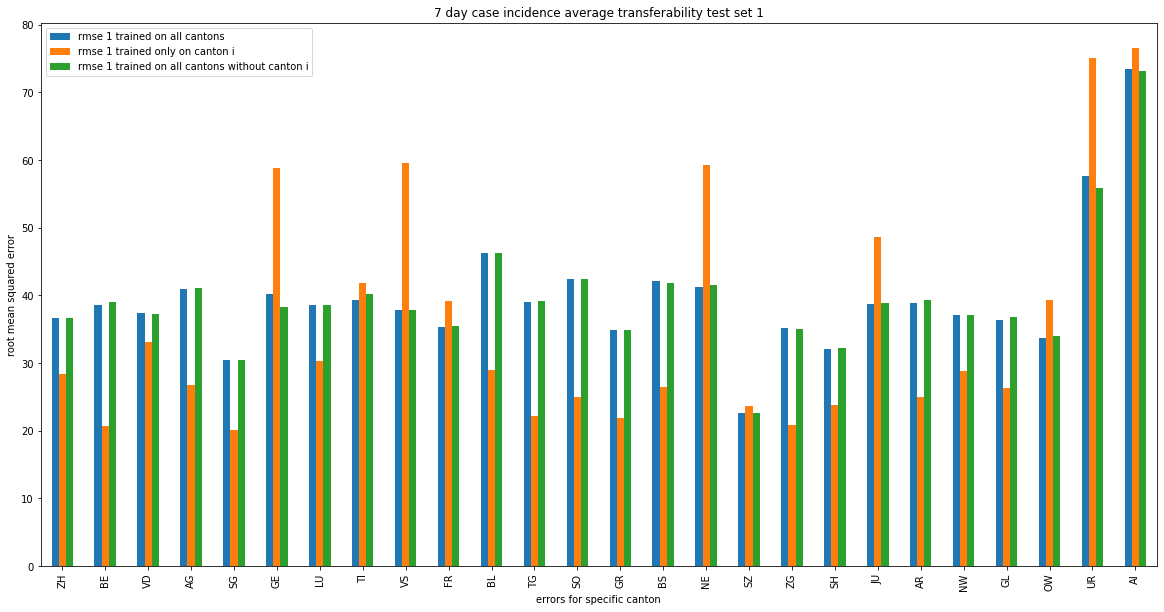

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,39.506515,35.788737,39.482304
std,9.141110,16.879449,8.978389
min,22.695614,20.117753,22.572138
25%,35.546496,24.144231,35.728208
50%,38.603228,28.603640,38.491287
75%,40.820535,41.179902,40.931418
max,73.413720,76.496727,73.236988


'Absolute correlations'

residents                                         1.000000
rmse 1 trained on all cantons                    -0.163087
rmse 1 trained on all cantons without canton i   -0.164744
rmse 1 trained only on canton i                  -0.232353
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: -7.78626482305821e-05
rel. diff. rmse 1 trained only on canton i mean: 0.10519078286108882


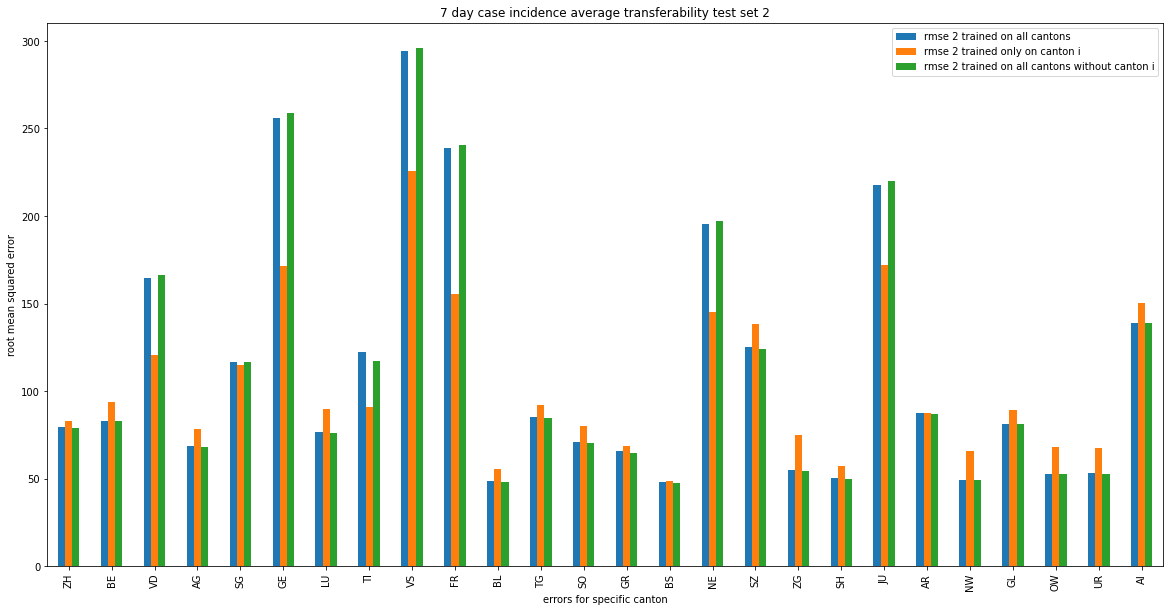

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,112.492416,103.301725,112.403185
std,71.877064,44.089654,72.826356
min,48.162904,48.844125,47.605909
25%,57.580534,70.465612,56.860347
50%,82.237683,89.523593,82.062227
75%,135.506122,133.962276,135.126174
max,293.992089,225.648829,295.707418


'Absolute correlations'

residents                                         1.000000
rmse 2 trained on all cantons without canton i    0.062927
rmse 2 trained on all cantons                     0.062727
rmse 2 trained only on canton i                   0.024817
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: 0.004840353361968043
rel. diff. rmse 2 trained only on canton i mean: -0.026049212558631928


'------------------------------------------------------------------------------------'

'hosp_inz_entries_7dayAverage'

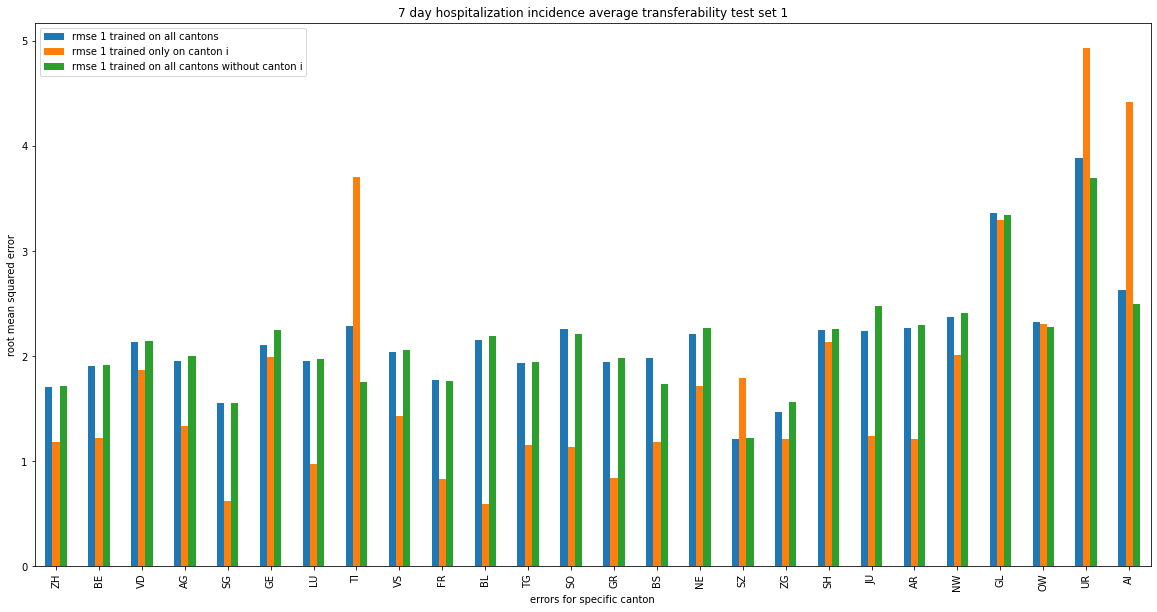

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,2.149004,1.780476,2.132282
std,0.534653,1.125557,0.513712
min,1.214647,0.593324,1.217334
25%,1.935335,1.162995,1.797882
50%,2.120582,1.286775,2.097497
75%,2.261829,2.003351,2.271003
max,3.884518,4.926333,3.692371


'Absolute correlations'

residents                                         1.000000
rmse 1 trained only on canton i                  -0.319050
rmse 1 trained on all cantons without canton i   -0.369320
rmse 1 trained on all cantons                    -0.372161
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: 0.0045134165413225754
rel. diff. rmse 1 trained only on canton i mean: 0.1998001684273047


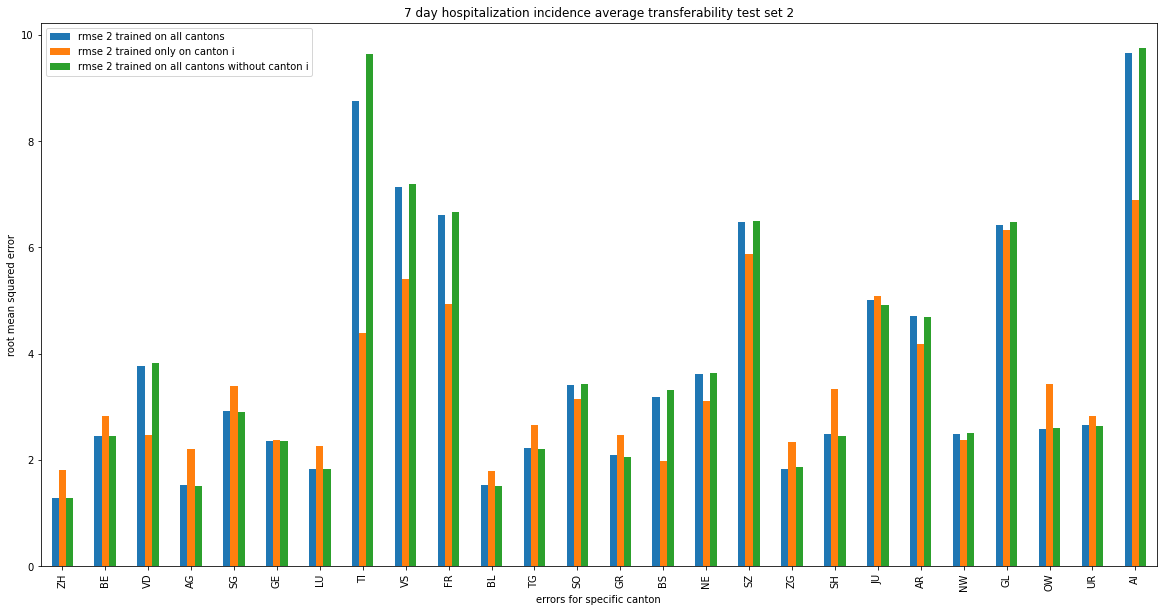

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,3.804840,3.455753,3.850855
std,2.327469,1.466346,2.424707
min,1.273824,1.788194,1.276813
25%,2.258965,2.368118,2.240588
50%,2.783516,2.970082,2.768264
75%,4.933316,4.338701,4.859232
max,9.656949,6.889239,9.739151


'Absolute correlations'

residents                                         1.000000
rmse 2 trained on all cantons without canton i   -0.304325
rmse 2 trained on all cantons                    -0.317167
rmse 2 trained only on canton i                  -0.404188
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.005591405994213591
rel. diff. rmse 2 trained only on canton i mean: -0.019969422558353947


'------------------------------------------------------------------------------------'

'death_inz_entries_7dayAverage'

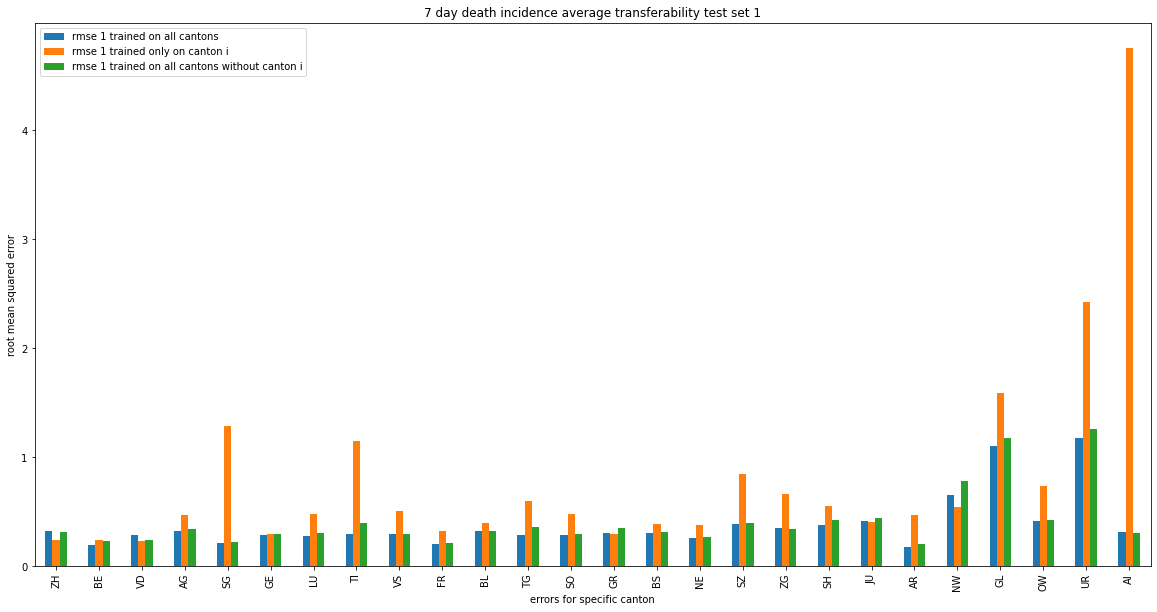

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,0.377604,0.797290,0.403716
std,0.242260,0.942782,0.264671
min,0.174076,0.231003,0.204577
25%,0.282865,0.383816,0.291765
50%,0.305063,0.478465,0.319467
75%,0.367704,0.714942,0.399158
max,1.175405,4.747207,1.259962


'Absolute correlations'

residents                                         1.000000
rmse 1 trained only on canton i                  -0.337052
rmse 1 trained on all cantons                    -0.337926
rmse 1 trained on all cantons without canton i   -0.357482
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.06719619220834394
rel. diff. rmse 1 trained only on canton i mean: -1.2833777308486338


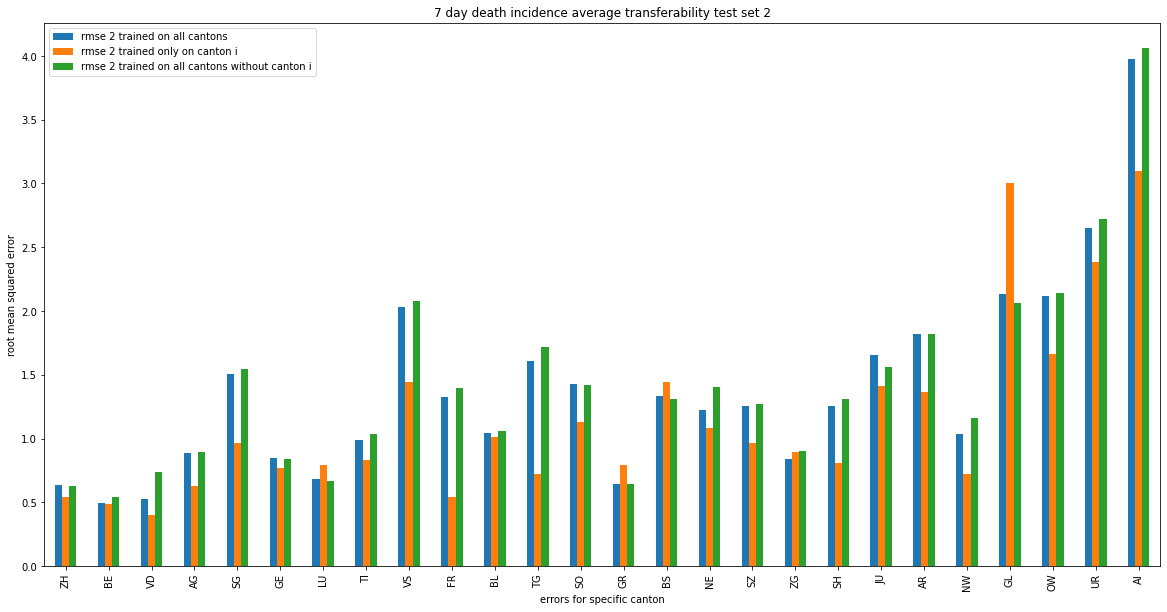

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,1.383155,1.150185,1.421171
std,0.763678,0.707269,0.764762
min,0.497787,0.399819,0.538688
25%,0.855857,0.733059,0.900189
50%,1.258964,0.927795,1.308333
75%,1.644968,1.401048,1.679027
max,3.973227,3.100794,4.058441


'Absolute correlations'

residents                                         1.000000
rmse 2 trained only on canton i                  -0.529830
rmse 2 trained on all cantons without canton i   -0.534881
rmse 2 trained on all cantons                    -0.539593
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.04012464765346931
rel. diff. rmse 2 trained only on canton i mean: 0.15326159734633027


'------------------------------------------------------------------------------------'

'testPositvity_7dayAverage'

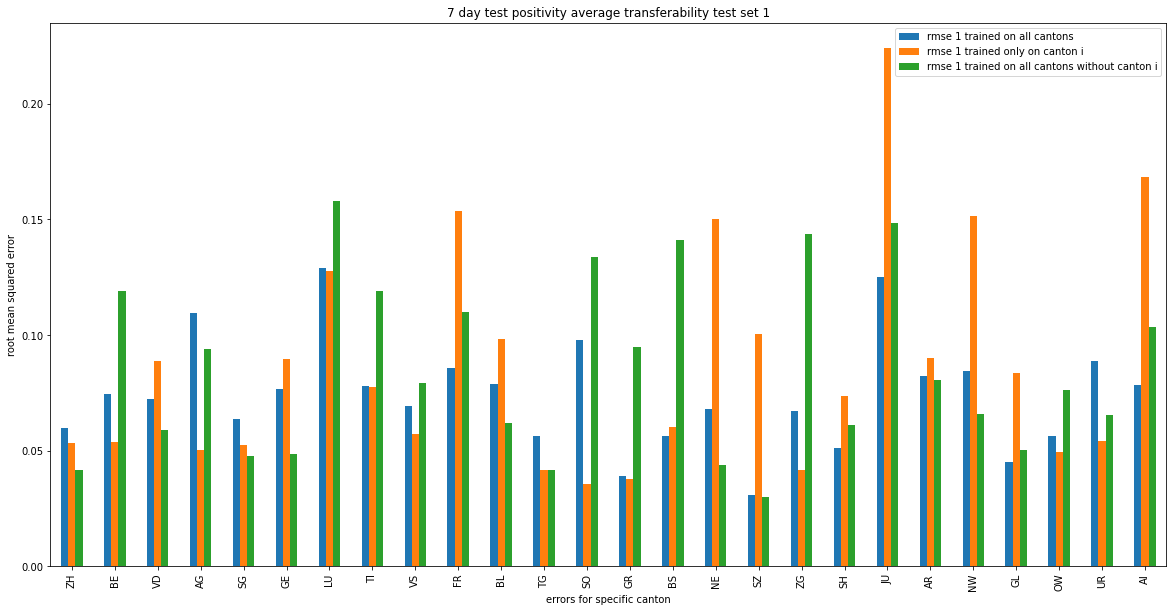

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,0.073923,0.087055,0.085295
std,0.023497,0.048302,0.038393
min,0.030932,0.035662,0.030039
25%,0.057052,0.052594,0.052281
50%,0.073351,0.075545,0.077654
75%,0.083762,0.100024,0.116676
max,0.128768,0.223867,0.157919


'Absolute correlations'

residents                                         1.000000
rmse 1 trained on all cantons                     0.042730
rmse 1 trained on all cantons without canton i   -0.115744
rmse 1 trained only on canton i                  -0.287826
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.18488813995163988
rel. diff. rmse 1 trained only on canton i mean: -0.2295286853226823


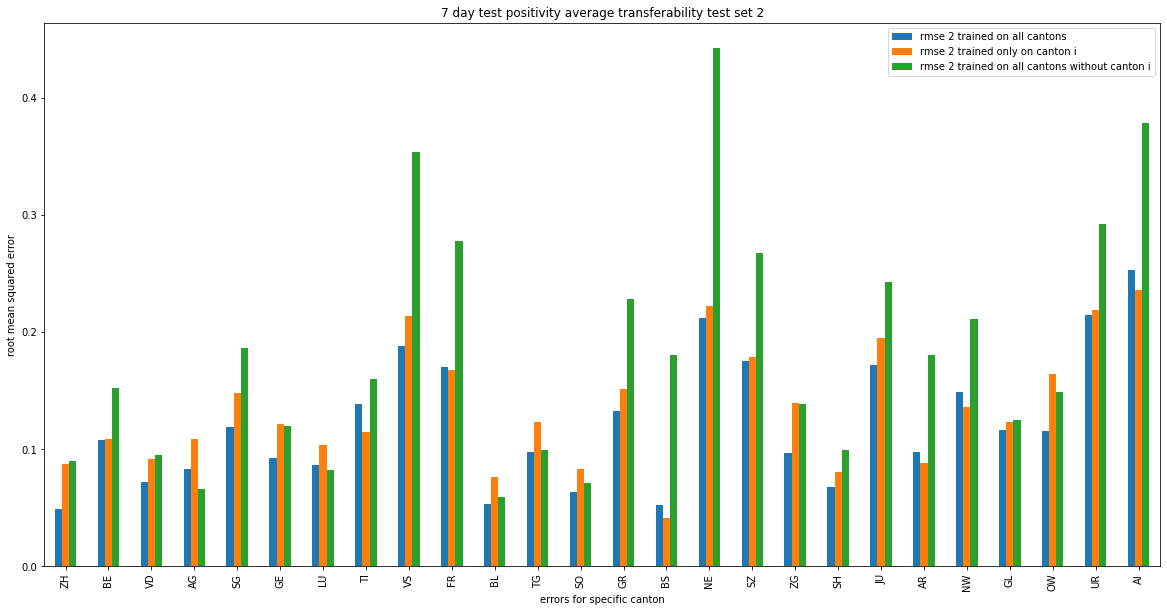

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,0.121949,0.135373,0.182419
std,0.055280,0.051539,0.102570
min,0.048427,0.040967,0.059262
25%,0.083774,0.094405,0.099300
50%,0.111282,0.123004,0.155869
75%,0.164716,0.166750,0.238818
max,0.252444,0.235699,0.441914


'Absolute correlations'

residents                                         1.000000
rmse 2 trained only on canton i                  -0.360167
rmse 2 trained on all cantons without canton i   -0.371973
rmse 2 trained on all cantons                    -0.430442
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.4883796371028776
rel. diff. rmse 2 trained only on canton i mean: -0.15820632246862645


'------------------------------------------------------------------------------------'

'transit_stations_percent_change_from_baseline_7dayAverage'

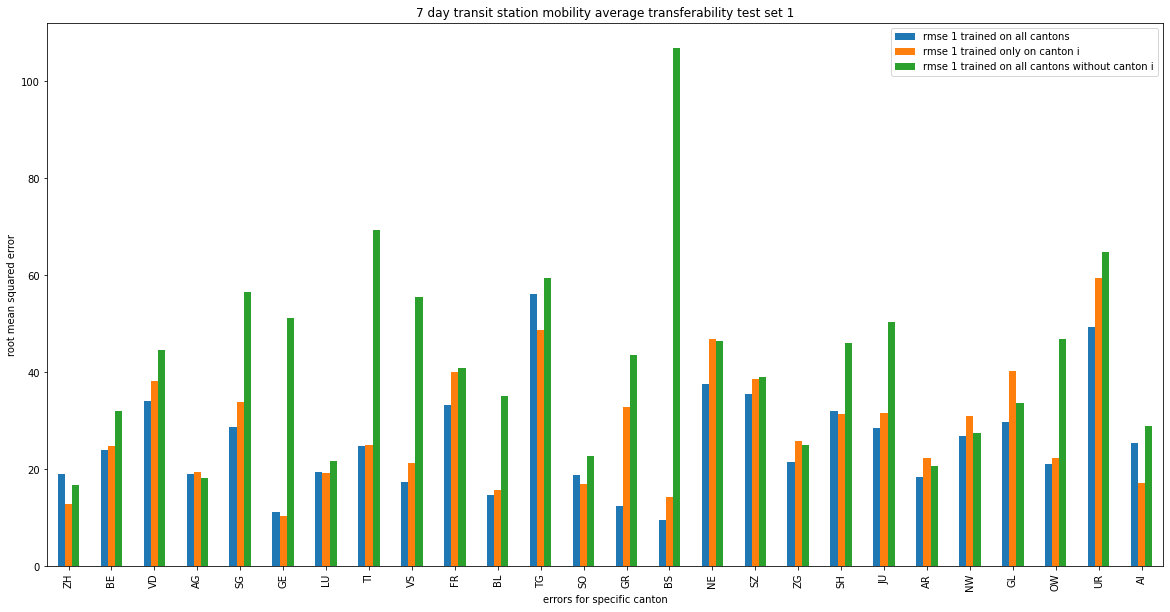

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,25.664187,28.431119,42.420244
std,11.012177,12.283172,19.718396
min,9.504918,10.330752,16.726138
25%,18.795884,19.214351,27.773478
50%,24.290432,25.332863,42.132436
75%,31.399113,37.023485,51.012395
max,56.123448,59.357010,106.703534


'Absolute correlations'

residents                                         1.000000
rmse 1 trained on all cantons                    -0.174664
rmse 1 trained on all cantons without canton i   -0.235809
rmse 1 trained only on canton i                  -0.307930
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: -1.0561210278583109
rel. diff. rmse 1 trained only on canton i mean: -0.14047295889354902


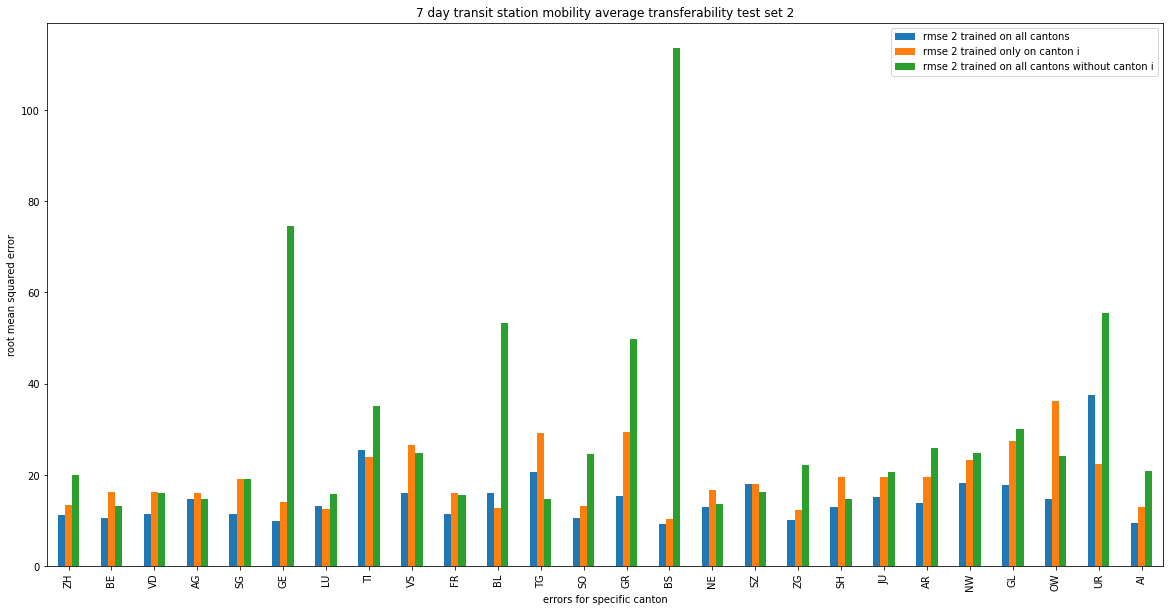

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,14.930700,19.145678,29.744979
std,5.984435,6.500647,22.960846
min,9.150800,10.311560,13.181447
25%,11.348575,13.660397,15.906180
50%,13.506468,17.354240,21.519144
75%,16.094498,23.100963,28.932562
max,37.535648,36.266794,113.485559


'Absolute correlations'

residents                                         1.000000
rmse 2 trained on all cantons without canton i   -0.159635
rmse 2 trained on all cantons                    -0.285508
rmse 2 trained only on canton i                  -0.322586
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: -1.2682110558930975
rel. diff. rmse 2 trained only on canton i mean: -0.33768140194242524


'------------------------------------------------------------------------------------'

'workplaces_percent_change_from_baseline_7dayAverage'

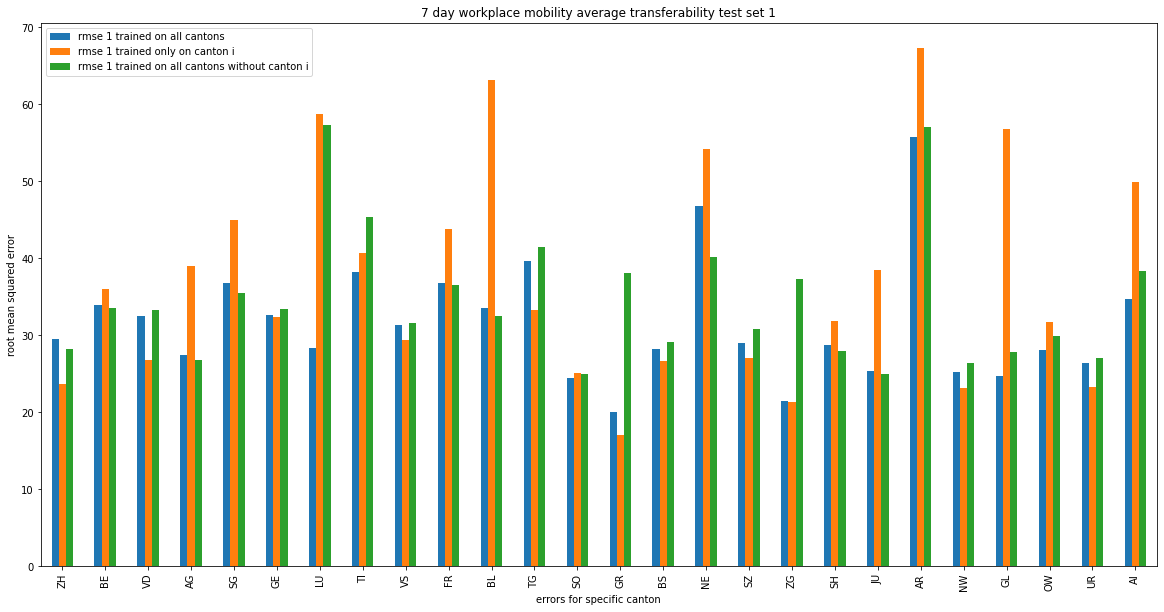

,rmse 1 trained on all cantons,rmse 1 trained only on canton i,rmse 1 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,31.520430,37.128789,34.416030
std,7.774050,13.938405,8.584574
min,20.058966,17.077168,24.893827
25%,26.636309,26.648509,27.981089
50%,29.237211,32.789946,32.830586
75%,34.474302,44.657571,37.919500
max,55.746938,67.226952,57.289108


'Absolute correlations'

residents                                         1.000000
rmse 1 trained on all cantons                     0.030730
rmse 1 trained on all cantons without canton i   -0.071367
rmse 1 trained only on canton i                  -0.163936
Name: residents, dtype: float64

rel. diff. rmse 1 trained on all cantons without canton i mean: -0.11920790806547282
rel. diff. rmse 1 trained only on canton i mean: -0.18113065288230373


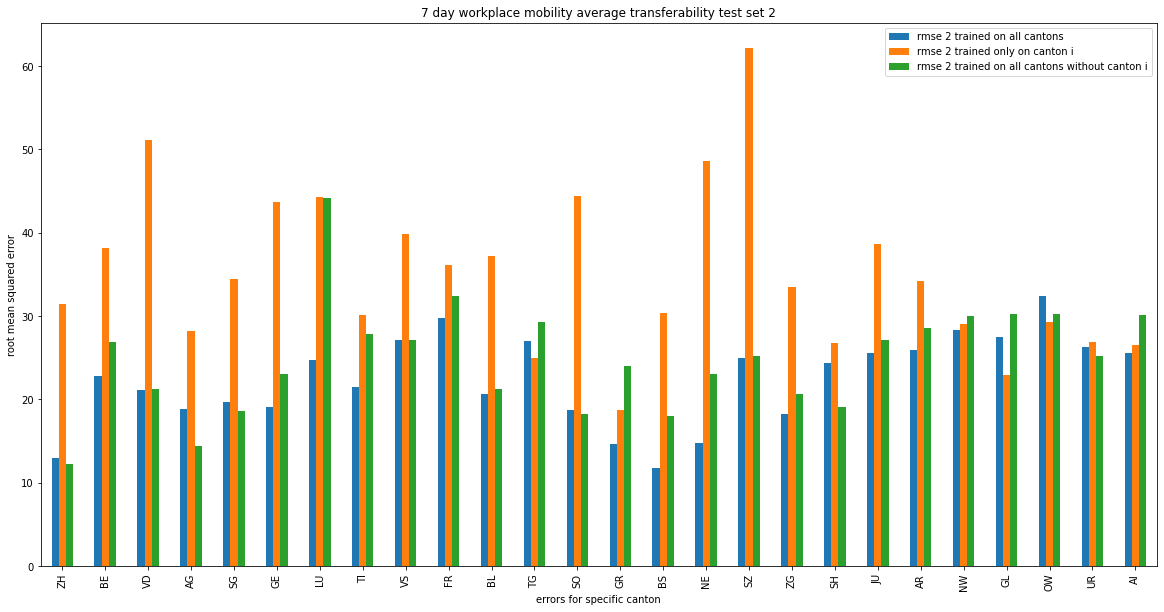

,rmse 2 trained on all cantons,rmse 2 trained only on canton i,rmse 2 trained on all cantons without canton i
count,26.000000,26.000000,26.000000
mean,22.497594,35.071617,24.945562
std,5.325813,9.752573,6.572261
min,11.806508,18.704933,12.317457
25%,18.947201,28.396048,20.793102
50%,23.614524,33.876598,25.195690
75%,26.180891,39.498959,29.112191
max,32.442670,62.110304,44.222300


'Absolute correlations'

residents                                         1.000000
rmse 2 trained only on canton i                   0.171816
rmse 2 trained on all cantons without canton i   -0.395310
rmse 2 trained on all cantons                    -0.426558
Name: residents, dtype: float64

rel. diff. rmse 2 trained on all cantons without canton i mean: -0.12832731083455406
rel. diff. rmse 2 trained only on canton i mean: -0.6618724291847925


'------------------------------------------------------------------------------------'

In [32]:
# TRANSFERABILITY TEST
experiment1 = pd.read_csv("transferability_results/allCantonalTraining/all.csv")
#display(experiment1)
experiment1 = experiment1.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment1.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons','model rmse 2':'rmse 2 trained on all cantons'}, inplace = True)
#display(experiment1)


experiment2 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment2 = experiment2.append(pd.read_csv("transferability_results/allWithoutCantonI/"+cantonId+".csv"))
experiment2 = experiment2.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment2.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons without canton i','model rmse 2':'rmse 2 trained on all cantons without canton i'}, inplace = True)
#display(experiment2)

experiment3 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment3 = experiment3.append(pd.read_csv("transferability_results/onlyCantonI/"+cantonId+".csv"))
experiment3 = experiment3.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment3.rename(columns = {'model rmse 1':'rmse 1 trained only on canton i','model rmse 2':'rmse 2 trained only on canton i'}, inplace = True)
#display(experiment3)


transferability = pd.concat([experiment1,experiment2,experiment3], axis=1).reset_index()
#display(transferability)

# calculate relative differences to benchmark (trained on all cantons)
# for experiment 2
transferability['rel. diff. rmse 1 trained on all cantons without canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained on all cantons without canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained on all cantons without canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained on all cantons without canton i'])/transferability['rmse 2 trained on all cantons']
# for experiment 3
transferability['rel. diff. rmse 1 trained only on canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained only on canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained only on canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained only on canton i'])/transferability['rmse 2 trained on all cantons']


#transferability = transferability.set_index('errorForCanton')

staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
cantonOrder = staticCantonal.sort_values(['residents'], ascending=False).index.tolist()
#display(staticCantonal.sort_values(['residents'], ascending=False).index.tolist())
'''
transferability = transferability.join(staticCantonal[['residents']])

transferability.sort_values(['residents'], inplace=True, ascending=False)
transferability = transferability.reset_index()
transferability.rename(columns = {'index':'errorForCanton'}, inplace = True)
'''
#display(transferability)


for task in outputCategories:
    display(task)
    temp = transferability[transferability['task']==task].set_index('errorForCanton').drop(['task'],axis=1)
    #display(temp)
    
    staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
    
    temp = temp.join(staticCantonal[['residents']])
    
    
    
    #display(temp)
    
    temp.sort_values('residents', inplace=True, ascending=False)
    #temp.sort_values('rmse 1 trained on all cantons', inplace=True)
    figure = temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 1",figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test1.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 1 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained on all cantons without canton i'])))
    print('rel. diff. rmse 1 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained only on canton i'])))
    
    
    #display("Relative correlations (attention when interpreting this)")
    #display(temp[['residents','rel. diff. rmse 1 trained on all cantons without canton i','rel. diff. rmse 1 trained only on canton i']].corr()['residents'].sort_values(ascending=False))
    
    
    
    #temp.sort_values('rmse 2 trained on all cantons', inplace=True)
    figure = temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 2", figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test2.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 2 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained on all cantons without canton i'])))
    print('rel. diff. rmse 2 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained only on canton i'])))
   
    display("------------------------------------------------------------------------------------")


In [37]:
# TRANSFERABILITY TEST
experiment1 = pd.read_csv("transferability_results/allCantonalTraining/all.csv")
#display(experiment1)
experiment1 = experiment1.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment1.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons','model rmse 2':'rmse 2 trained on all cantons'}, inplace = True)
#display(experiment1)


experiment2 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment2 = experiment2.append(pd.read_csv("transferability_results/allWithoutCantonI/"+cantonId+".csv"))
experiment2 = experiment2.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment2.rename(columns = {'model rmse 1':'rmse 1 trained on all cantons without canton i','model rmse 2':'rmse 2 trained on all cantons without canton i'}, inplace = True)
#display(experiment2)

experiment3 = pd.DataFrame()
for cantonId in cantonKeys:
    experiment3 = experiment3.append(pd.read_csv("transferability_results/onlyCantonI/"+cantonId+".csv"))
experiment3 = experiment3.groupby(['errorForCanton','task','week']).median().reset_index().groupby(['errorForCanton','task']).sum().drop(['week','iteration'], axis=1)
experiment3.rename(columns = {'model rmse 1':'rmse 1 trained only on canton i','model rmse 2':'rmse 2 trained only on canton i'}, inplace = True)
#display(experiment3)


transferability = pd.concat([experiment1,experiment2,experiment3], axis=1).reset_index()
#display(transferability)

# calculate relative differences to benchmark (trained on all cantons)
# for experiment 2
transferability['rel. diff. rmse 1 trained on all cantons without canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained on all cantons without canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained on all cantons without canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained on all cantons without canton i'])/transferability['rmse 2 trained on all cantons']
# for experiment 3
transferability['rel. diff. rmse 1 trained only on canton i'] = (transferability['rmse 1 trained on all cantons']-transferability['rmse 1 trained only on canton i'])/transferability['rmse 1 trained on all cantons']
transferability['rel. diff. rmse 2 trained only on canton i'] = (transferability['rmse 2 trained on all cantons']-transferability['rmse 2 trained only on canton i'])/transferability['rmse 2 trained on all cantons']


#transferability = transferability.set_index('errorForCanton')

staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
cantonOrder = staticCantonal.sort_values(['residents'], ascending=False).index.tolist()
#display(staticCantonal.sort_values(['residents'], ascending=False).index.tolist())
'''
transferability = transferability.join(staticCantonal[['residents']])

transferability.sort_values(['residents'], inplace=True, ascending=False)
transferability = transferability.reset_index()
transferability.rename(columns = {'index':'errorForCanton'}, inplace = True)
'''
#display(transferability)

'''
for task in outputCategories:
    display(task)
    temp = transferability[transferability['task']==task].set_index('errorForCanton').drop(['task'],axis=1)
    #display(temp)
    
    staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
    
    temp = temp.join(staticCantonal[['residents']])
    
    
    
    #display(temp)
    
    temp.sort_values('residents', inplace=True, ascending=False)
    #temp.sort_values('rmse 1 trained on all cantons', inplace=True)
    figure = temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 1",figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test1.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 1 trained on all cantons','rmse 1 trained only on canton i','rmse 1 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 1 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained on all cantons without canton i'])))
    print('rel. diff. rmse 1 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 1 trained only on canton i'])))
    
    
    #display("Relative correlations (attention when interpreting this)")
    #display(temp[['residents','rel. diff. rmse 1 trained on all cantons without canton i','rel. diff. rmse 1 trained only on canton i']].corr()['residents'].sort_values(ascending=False))
    
    
    
    #temp.sort_values('rmse 2 trained on all cantons', inplace=True)
    figure = temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].plot(kind='bar', title=plottingDict[task]+" transferability test set 2", figsize=(20,10))
    figure.set_ylabel("root mean squared error")
    figure.set_xlabel("errors for specific canton")
    plt.show()
    figure.get_figure().savefig('plots/transferability/'+task+'_test2.png', bbox_inches=matplotlib.transforms.Bbox([[1.8, 0.7], [18.2, 9.2]]))
    display(temp[['rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].describe())
    # correlation between rmse and population size
    display("Absolute correlations")
    display(temp[['residents','rmse 2 trained on all cantons','rmse 2 trained only on canton i','rmse 2 trained on all cantons without canton i']].corr()['residents'].sort_values(ascending=False))
    
    print('rel. diff. rmse 2 trained on all cantons without canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained on all cantons without canton i'])))
    print('rel. diff. rmse 2 trained only on canton i mean: '+str(np.mean(temp['rel. diff. rmse 2 trained only on canton i'])))
   
    display("------------------------------------------------------------------------------------")
'''
test1 = transferability[['errorForCanton','task','rmse 1 trained on all cantons','rmse 1 trained on all cantons without canton i','rmse 1 trained only on canton i']].copy()
test2 = transferability[['errorForCanton','task','rmse 2 trained on all cantons','rmse 2 trained on all cantons without canton i','rmse 2 trained only on canton i']].copy()


# 0 if only on canton i is best
# 1 if without canton i is best
# 2 otherwise
i1 = test1[(test1['rmse 1 trained on all cantons without canton i'] > test1['rmse 1 trained on all cantons']) & 
      (test1['rmse 1 trained on all cantons without canton i'] > test1['rmse 1 trained only on canton i'])].index
test1.loc[i1,['best']] = 1
i2 = test1[(test1['rmse 1 trained only on canton i'] > test1['rmse 1 trained on all cantons']) & 
      (test1['rmse 1 trained only on canton i'] > test1['rmse 1 trained on all cantons without canton i'])].index
test1.loc[i2,['best']] = 0
test1['best'].fillna(2, inplace = True)


j1 = test2[(test2['rmse 2 trained on all cantons without canton i'] > test2['rmse 2 trained on all cantons']) & 
      (test2['rmse 2 trained on all cantons without canton i'] > test2['rmse 2 trained only on canton i'])].index
test2.loc[j1,['best']] = 1
j2 = test2[(test2['rmse 2 trained only on canton i'] > test2['rmse 2 trained on all cantons']) & 
      (test2['rmse 2 trained only on canton i'] > test2['rmse 2 trained on all cantons without canton i'])].index
test2.loc[j2,['best']] = 0
test2['best'].fillna(2, inplace = True)



def collorMap(val):
    if val == 0:
        color = 'orange'
    elif val == 1:
        color = 'green'
    else:
        color = 'blue'
    return 'background-color: %s' % color

def collorMap2(val):
    if val == 0:
        color = 'orange'
    elif val == 1:
        color = 'green'
    else:
        color = 'blue'
    return 'color: %s' % color
  
test1 = test1[['errorForCanton','task','best']].pivot(index='task', columns='errorForCanton')
test1.columns = [y for (x,y) in test1.columns]


test2 = test2[['errorForCanton','task','best']].pivot(index='task', columns='errorForCanton')
test2.columns = [y for (x,y) in test2.columns]

test1 = test1[cantonOrder]
test1 = test1.astype(int)
test1.rename(index = {'case_inz_entries_7dayAverage':'7 day case incidence average',
                      'death_inz_entries_7dayAverage':'7 day death incidence average',
                      'hosp_inz_entries_7dayAverage':'7 day hospitalization incidence average',
                      'testPositvity_7dayAverage':'7 day test positivity average',
                      'transit_stations_percent_change_from_baseline_7dayAverage':'7 day transit station mobility average',
                      'workplaces_percent_change_from_baseline_7dayAverage':'7 day workplace mobility average'
                     }, inplace = True)

reorderlist = ['7 day case incidence average',
               '7 day hospitalization incidence average',
               '7 day death incidence average',
               '7 day test positivity average',
               '7 day transit station mobility average',
               '7 day workplace mobility average'
              ]
test1 = test1.reindex(reorderlist)

test1 = test1.style.applymap(collorMap).applymap(collorMap2)


test2 = test2[cantonOrder]
test2 = test2.astype(int)
test2.rename(index = {'case_inz_entries_7dayAverage':'7 day case incidence average',
                      'death_inz_entries_7dayAverage':'7 day death incidence average',
                      'hosp_inz_entries_7dayAverage':'7 day hospitalization incidence average',
                      'testPositvity_7dayAverage':'7 day test positivity average',
                      'transit_stations_percent_change_from_baseline_7dayAverage':'7 day transit station mobility average',
                      'workplaces_percent_change_from_baseline_7dayAverage':'7 day workplace mobility average'
                     }, inplace = True)

test2 = test2.reindex(reorderlist)

test2 = test2.style.applymap(collorMap).applymap(collorMap2)

display(test1)
display(test2)


,ZH,BE,VD,AG,SG,GE,LU,TI,VS,FR,BL,TG,SO,GR,BS,NE,SZ,ZG,SH,JU,AR,NW,GL,OW,UR,AI
task,,,,,,,,,,,,,,,,,,,,,,,,,,
7 day case incidence average,2,1,2,1,2,0,1,0,0,0,2,1,1,2,2,0,0,2,1,0,1,1,1,0,0,0
7 day hospitalization incidence average,1,1,1,1,1,1,1,0,1,2,1,1,2,1,2,1,0,1,1,1,1,1,2,2,0,0
7 day death incidence average,2,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
7 day test positivity average,2,1,0,2,2,0,1,1,1,0,0,2,1,1,1,0,0,1,0,0,0,0,0,1,2,0
7 day transit station mobility average,2,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,1,1,1
7 day workplace mobility average,2,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,1,0


,ZH,BE,VD,AG,SG,GE,LU,TI,VS,FR,BL,TG,SO,GR,BS,NE,SZ,ZG,SH,JU,AR,NW,GL,OW,UR,AI
task,,,,,,,,,,,,,,,,,,,,,,,,,,
7 day case incidence average,0,0,1,0,1,1,0,2,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
7 day hospitalization incidence average,0,0,1,0,0,0,0,1,1,1,0,0,1,0,1,1,1,0,0,0,2,1,1,0,0,1
7 day death incidence average,2,1,1,1,1,2,0,1,1,1,1,1,2,0,0,1,1,1,1,2,1,1,0,1,1,1
7 day test positivity average,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1
7 day transit station mobility average,1,0,0,0,1,1,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,1,1
7 day workplace mobility average,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,2,0,1


In [ ]:
# TEMPORAL TEST
'''
for experimentNumber in range(0,3):
    df = pd.read_csv("temporal/experiment"+str(experimentNumber)+".csv")
    #df = df.drop(["Unnamed: 0","iteration"], axis=1).set_index("cantonId")
    df = df.groupby(['cantonId']).median().drop(["Unnamed: 0","iteration"], axis=1)
    df.plot(kind="box", figsize=(20,10))
    plt.show()
    display(df)
    display(df.describe())
'''



In [ ]:
'''
# Helper to get the top models for retraining
pd.options.display.max_rows = 50
rankedTasksDict['case_inz_entries_7dayAverage'].head(8).to_csv("top_sklearn/case_inz_entries_7dayAverage.csv")
rankedTasksDict['hosp_inz_entries_7dayAverage'].head(6).to_csv("top_sklearn/hosp_inz_entries_7dayAverage.csv")
temp = rankedTasksDict['death_inz_entries_7dayAverage']
temp = temp[temp['overallRank']<=30]
temp.to_csv("top_sklearn/death_inz_entries_7dayAverage.csv")
rankedTasksDict['workplaces_percent_change_from_baseline_7dayAverage'].head(7).to_csv("top_sklearn/workplaces_percent_change_from_baseline_7dayAverage.csv")
'''

In [ ]:
'''
temporal = pd.read_csv("temporal_results/testPositivityPartialRetrained.csv")
temporal2 = pd.read_csv("temporal_results/testPositivityWithTestModel.csv")
temporal3 = pd.read_csv("temporal_results/testPositivityWithValidModel.csv")

temporal4 = pd.read_csv("temporal_results/deathsWithValidModel.csv")
temporal5 = pd.read_csv("temporal_results/deathsWithTestModel.csv")

temporal = temporal.set_index('lastInputDay').drop(['Unnamed: 0'], axis=1)

temporal2 = temporal2.set_index('lastInputDay').drop(['Unnamed: 0'], axis=1)
temporal3 = temporal3.set_index('lastInputDay').drop(['Unnamed: 0'], axis=1)
display(temporal2)
temporal4 = temporal4.set_index('lastInputDay').drop(['Unnamed: 0'], axis=1)
temporal5 = temporal5.set_index('lastInputDay').drop(['Unnamed: 0'], axis=1)
#display(temporal)

#temporal[['baseline rmse week 1','pred rmse week 1']].plot(kind='line', figsize=(20,10))
#temporal[['baseline rmse week 2','pred rmse week 2']].plot(kind='line', figsize=(20,10))
#temporal[['baseline rmse week 3','pred rmse week 3']].plot(kind='line', figsize=(20,10))
#temporal[['baseline rmse week 4','pred rmse week 4']].plot(kind='line', figsize=(20,10))

temporal[['last_value_baseline_rmse','model rmse']].plot(kind='line', figsize=(20,10), title="Chosen test positvity model (retrained every day)")

temporal3[['last_value_baseline_rmse','model rmse']].plot(kind='line', figsize=(20,10), title="Model trained on training")
#temporal[['rel. diff. to last value baseline 1']].plot(kind='line', figsize=(20,10))
temporal2[['last_value_baseline_rmse','model rmse']].plot(kind='line', figsize=(20,10), title="Model trained on training + validation data")

#temporal4[['last_value_baseline_rmse','model rmse']].plot(kind='line', figsize=(20,10), title="Model trained on training")

#temporal5[['last_value_baseline_rmse','model rmse']].plot(kind='line', figsize=(20,10), title="Model trained on training")
'''

In [ ]:
'''
def buil_model():
    return keras.models.Sequential()
task = 'testPositvity_7dayAverage'
estimator = keras.wrappers.scikit_learn.KerasRegressor(buil_model, verbose=0)
estimator.model = keras.models.load_model("models/trainedOnTrainingData/12483_testPositvity_7dayAverage")
'''
'''
estimator = load("models/trainedOnTrainingAndValidationData/207_death_inz_entries_7dayAverage_sklearn.pkl")


results = pd.DataFrame()
for e in pd.date_range(start=pd.Timestamp('2020-05-28'),end=pd.Timestamp('2021-05-28'), freq='D'): #'2021-05-28'

    data0 = data[(data['lastInputDay']<=str(e.date()))].copy()
    data0[['category']] = 'train'
    data0.loc[(data0['lastInputDay']>=str((e-timedelta(days = 28)).date())),['category']] = 'test'

    print(e.date())

    df = data0

    pip = Pipeline([('minmax_scaler', MinMaxScaler())])
    train_features_all = df[(df['category']=='train')].iloc[:,0:-split].set_index('lastInputDay')
    test_features_all = df[(df['category']=='test')].iloc[:,0:-split].set_index('lastInputDay')
    train_labels_all = df[df['category']=='train'].set_index('lastInputDay').iloc[:,-split:-2]
    test_labels_all = df[df['category']=='test'].set_index('lastInputDay').iloc[:,-split:-2] 

    train_features_all_scaled = pip.fit_transform(train_features_all.values)
    test_features_all_scaled = pip.transform(test_features_all.values)


    #estimator.fit(train_features_all_scaled, train_labels_all[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]].values)
    '''
    #estimator.fit(train_features_all_scaled, 
    #      train_labels_all[["output_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]].values, 
    #      batch_size=32, 
    #      epochs=estimators[task]["epochs"], 
    #      verbose=0)
    '''

    predictions = pd.DataFrame(estimator.predict(test_features_all_scaled), 
                                index=test_labels_all.index, 
                                columns=["pred_week_"+task+"_"+str(outputWeekNumber) for outputWeekNumber in range(0,numberOfOutputWeeks)]) 
    #display(predictions)

    last_value_baseline = test_features_all[[task+"_last_"+str(numberOfInputWeeks-1)]]
    #display(last_value_baseline)

    sumRsme = 0
    sumBaselineRsme = 0

    res = {
        'lastInputDay': e.date()
        }

    for outputWeekNumber in range(1,numberOfOutputWeeks+1):
        y_test1 = test_labels_all[["output_"+task+"_"+str(outputWeekNumber-1)]]
        rmse = np.sqrt(mean_squared_error(predictions["pred_week_"+task+"_"+str(outputWeekNumber-1)], y_test1["output_"+task+"_"+str(outputWeekNumber-1)]))
        res['pred rmse week '+str(outputWeekNumber)] = rmse


        last_value_baseline_rmse = np.sqrt(mean_squared_error(last_value_baseline,y_test1["output_"+task+"_"+str(outputWeekNumber-1)]))
        res['baseline rmse week '+str(outputWeekNumber)] = last_value_baseline_rmse


    results = results.append(res, ignore_index=True)

    results['model rmse'] = results[['pred rmse week '+str(outputWeekNumber) for outputWeekNumber in range(1,numberOfOutputWeeks+1)]].sum(axis=1)
    results['last_value_baseline_rmse'] = results[['baseline rmse week '+str(outputWeekNumber) for outputWeekNumber in range(1,numberOfOutputWeeks+1)]].sum(axis=1)

    results['rel. diff. to last value baseline 1'] = (results['last_value_baseline_rmse']-results['model rmse'])/results['last_value_baseline_rmse']

if not os.path.exists('temporal_results/'):
    os.makedirs('temporal_results/') 
results.to_csv("temporal_results/deathsWithTestModel.csv")
'''

['Cases inz_entries female',
 'Cases inz_entries male',
 'Cases inzsumTotal female',
 'Cases inzsumTotal male',
 'Death inz_entries female',
 'Death inz_entries male',
 'Death inzsumTotal female',
 'Death inzsumTotal male',
 'Hosp inz_entries female',
 'Hosp inz_entries male',
 'Hosp inzsumTotal female',
 'Hosp inzsumTotal male',
 'AtLeastOneDosePersons per100PersonsTotal',
 'COVID19FullyVaccPersons per100PersonsTotal',
 'prct_B.1.1.7',
 'prct_B.1.351',
 'prct_P.1',
 'prct_P.2',
 'prct_B.1.617.1',
 'prct_B.1.617.2',
 'prct_B.1.525',
 'prct_B.1.526',
 'case_entries',
 'case_inz_entries',
 'case_inzsumTotal',
 'hosp_inz_entries',
 'hosp_inzsumTotal',
 'death_inz_entries',
 'death_inzsumTotal',
 'test_entries',
 'test_inz_entries',
 'test_inzsumTotal',
 'median_R_mean',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_cha

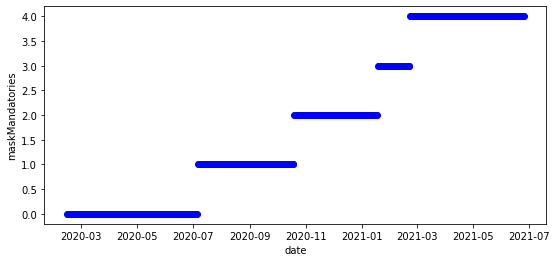

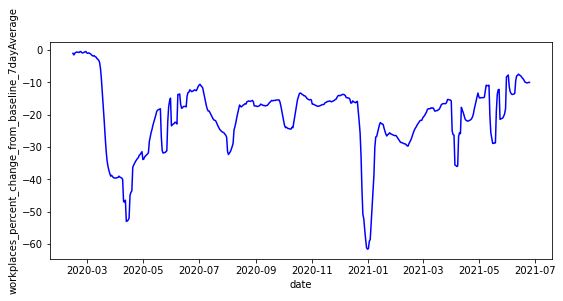

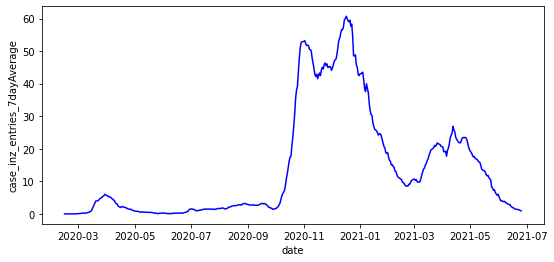

In [110]:
# visualize preperation process
start = '2020-02-15'
end = '2021-06-25'
cantonId = 'AG'

raw = pd.read_csv("data/merged/"+cantonId+".csv").set_index('date')[start:end]
raw.index = pd.to_datetime(raw.index)

processed = pd.read_csv("data/dailyFeatures/"+cantonId+".csv").set_index('date')
processed.index = pd.to_datetime(processed.index)

'''
for feature in processed.columns:
    if (feature in raw.columns):
        display(feature)
        d = pd.concat([raw[[feature]], processed[feature]],axis=1)
        d.columns = ['raw','filled & processed']

        d = d.reset_index()

        plt.figure(figsize=(9,4))
        
        plt.scatter(d['date'],
                d['filled & processed'],
               label='filled & processed',
               color='red',
               alpha=1)
        
        plt.scatter(d['date'],
                d['raw'],
               marker='o',
               color='blue',
               label='raw',
               alpha=1)
        
        plt.xlabel('date')
        plt.ylabel(feature)
        plt.legend()
        plt.savefig('plots/preparation/'+feature.replace(" ","").replace("/","")+'_'+cantonId+'.png')
        plt.show()
'''

display(processed.columns.tolist())
processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.scatter(processed['date'],
        processed['maskMandatories'],
       label='raw',
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('maskMandatories')
plt.savefig('plots/preparation/'+'maskMandatories_'+cantonId+'.png')
plt.show()


processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.plot(processed['date'],
        processed['workplaces_percent_change_from_baseline_7dayAverage'],
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('workplaces_percent_change_from_baseline_7dayAverage')
plt.savefig('plots/preparation/'+'workplace_'+cantonId+'.png')
plt.show()

processed = processed.reset_index()
plt.figure(figsize=(9,4))
plt.plot(processed['date'],
        processed['case_inz_entries_7dayAverage'],
       color='blue',
       alpha=1)
plt.xlabel('date')
plt.ylabel('case_inz_entries_7dayAverage')
plt.savefig('plots/preparation/'+'caseIncidenceAverage_'+cantonId+'.png')
plt.show()




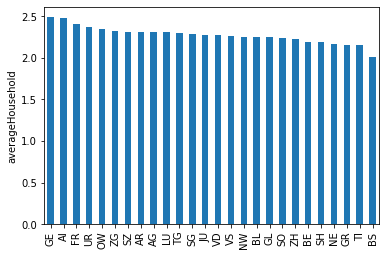

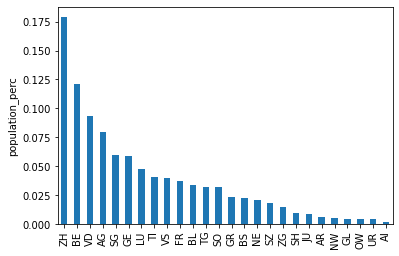

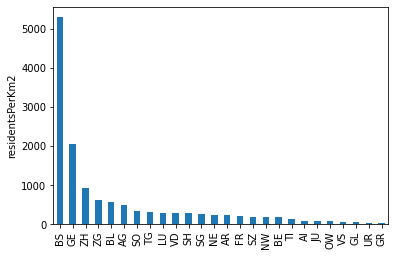

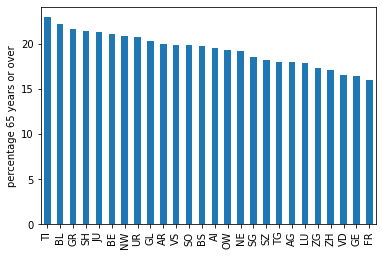

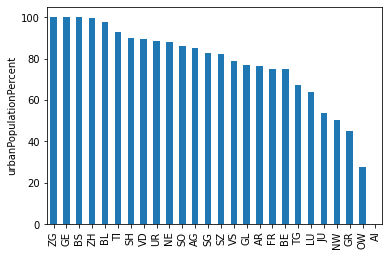

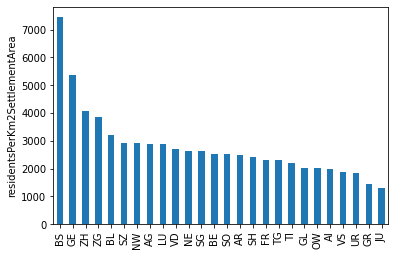

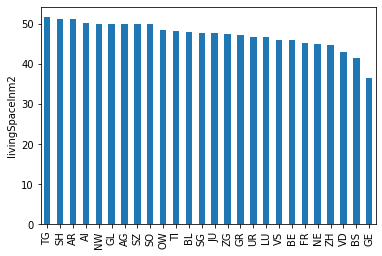

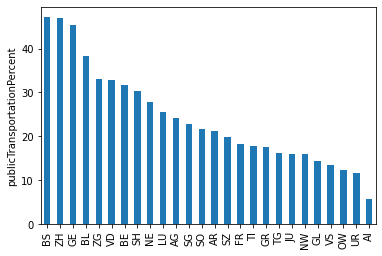

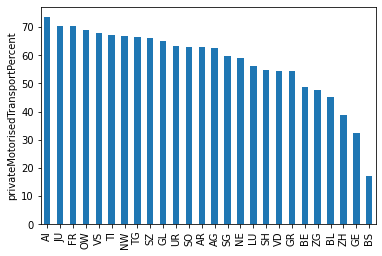

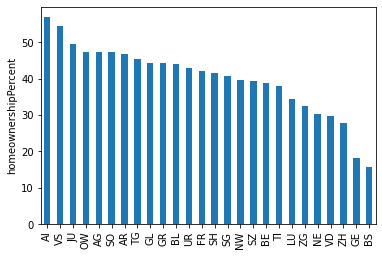

In [95]:
staticCantonal = pd.read_excel("static_data/staticCantonalData.xlsx").set_index('canton').transpose()
  

    
staticCantonal[['averageHousehold']] = staticCantonal['residents']/staticCantonal['totalHousholds']

staticCantonal[['residentsPerKm2SettlementArea']] = staticCantonal['residents']/(staticCantonal['areaInKm2']*(staticCantonal['settlementAreaPercent']/100))
staticCantonal[['population_perc']] = staticCantonal['residents']/staticCantonal['residents'].sum()


staticCantonal[['averageHousehold']].sort_values('averageHousehold',ascending=False).plot(kind='bar', ylabel='averageHousehold', legend=False)
plt.savefig('plots/preparation/'+'averageHousehold'+'.png')
staticCantonal[['population_perc']].sort_values('population_perc',ascending=False).plot(kind='bar', ylabel='population_perc', legend=False)
plt.savefig('plots/preparation/'+'population_perc'+'.png')
staticCantonal[['residentsPerKm2']].sort_values('residentsPerKm2',ascending=False).plot(kind='bar', ylabel='residentsPerKm2', legend=False)
plt.savefig('plots/preparation/'+'residentsPerKm2'+'.png')
staticCantonal[['percentage 65 years or over']].sort_values('percentage 65 years or over',ascending=False).plot(kind='bar', ylabel='percentage 65 years or over', legend=False)
plt.savefig('plots/preparation/'+'percentage65yearsorover'+'.png')
staticCantonal[['urbanPopulationPercent']].sort_values('urbanPopulationPercent',ascending=False).plot(kind='bar', ylabel='urbanPopulationPercent', legend=False)
plt.savefig('plots/preparation/'+'urbanPopulationPercent'+'.png')
staticCantonal[['residentsPerKm2SettlementArea']].sort_values('residentsPerKm2SettlementArea',ascending=False).plot(kind='bar', ylabel='residentsPerKm2SettlementArea', legend=False)
plt.savefig('plots/preparation/'+'residentsPerKm2SettlementArea'+'.png')
staticCantonal[['livingSpaceInm2']].sort_values('livingSpaceInm2',ascending=False).plot(kind='bar', ylabel='livingSpaceInm2', legend=False)
plt.savefig('plots/preparation/'+'livingSpaceInm2'+'.png')
staticCantonal[['publicTransportationPercent']].sort_values('publicTransportationPercent',ascending=False).plot(kind='bar', ylabel='publicTransportationPercent', legend=False)
plt.savefig('plots/preparation/'+'publicTransportationPercent'+'.png')
staticCantonal[['privateMotorisedTransportPercent']].sort_values('privateMotorisedTransportPercent',ascending=False).plot(kind='bar', ylabel='privateMotorisedTransportPercent', legend=False)
plt.savefig('plots/preparation/'+'privateMotorisedTransportPercent'+'.png')
staticCantonal[['homeownershipPercent']].sort_values('homeownershipPercent',ascending=False).plot(kind='bar', ylabel='homeownershipPercent', legend=False)
plt.savefig('plots/preparation/'+'homeownershipPercent'+'.png')

